In [1]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn
import json
import datetime
import pickle
import seaborn as sns
import gc
import psutil
import math
import scipy.stats as stats
from matplotlib.patches import Patch
from nilearn import plotting
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.image import concat_imgs, mean_img, index_img
from nilearn.reporting import make_glm_report
from nilearn import masking, image
from nilearn import datasets
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from collections import defaultdict
from nilearn.maskers import NiftiLabelsMasker
from nilearn.plotting.find_cuts import find_cut_slices
import nibabel as nib

In [2]:
# general helper functions:
def cleanup_memory():
    """
    Clean up memory between batches
    """
    # Force garbage collection
    gc.collect()
    
    # Get memory info
    memory = psutil.virtual_memory()
    print(f"Memory after cleanup: {memory.percent:.1f}% used ({memory.available/(1024**3):.1f}GB available)")

In [3]:
# all tasks and contrasts
TASKS = ["nBack","flanker","directedForgetting","goNogo", "shapeMatching", "stopSignal", "cuedTS", "spatialTS"]
CONTRASTS = {}
CONTRASTS["nBack"] = ["twoBack-oneBack", "match-mismatch","task-baseline","response_time"] # the nback contrasts
CONTRASTS["flanker"] = ["incongruent-congruent", "task-baseline"]
CONTRASTS["directedForgetting"] = ["neg-con", "task-baseline","response_time"]
CONTRASTS["goNogo"] = ["nogo_success-go", "nogo_success","task-baseline","response_time"] # go_rtModel check
CONTRASTS["shapeMatching"] = ["DDD", "DDS", "DNN", "DSD", "main_vars", "SDD", "SNN", "SSS", "task-baseline","response_time"]
CONTRASTS["stopSignal"] = ["go", "stop_failure-go", "stop_failure", "stop_failure-stop_success", "stop_success-go", "stop_success", "stop_success-stop_failure", "task-baseline","response_time"]
CONTRASTS["cuedTS"] = ["cue_switch_cost", "task_switch_cost", "task_switch_cue_switch-task_stay_cue_stay", "task-baseline","response_time"]
CONTRASTS["spatialTS"] = ["cue_switch_cost", "task_switch_cost", "task_switch_cue_switch-task_stay_cue_stay", "task-baseline","response_time"]

# interested in looking at them all now:
requested_task_contrasts = defaultdict(lambda: defaultdict(list))
requested_task_contrasts['nBack'] = CONTRASTS["nBack"]
requested_task_contrasts['flanker'] = CONTRASTS["flanker"]
requested_task_contrasts['directedForgetting'] = CONTRASTS["directedForgetting"]
requested_task_contrasts['goNogo'] = CONTRASTS["goNogo"]
requested_task_contrasts['shapeMatching'] = CONTRASTS["shapeMatching"]
requested_task_contrasts['stopSignal'] = CONTRASTS["stopSignal"]
requested_task_contrasts['cuedTS'] = CONTRASTS["cuedTS"]
requested_task_contrasts['spatialTS'] = CONTRASTS["spatialTS"] 

# compiled_req_contrasts = ["twoBack-oneBack", 'task-baseline', "incongruent-congruent", "neg-con", "nogo_success-go", "main_vars", "stop_failure-go","task_switch_cost"]
# compile all requested contrasts into one list
compiled_req_contrasts = []
for task in TASKS:
    for contrast in requested_task_contrasts[task]:
        if (contrast not in compiled_req_contrasts):
            compiled_req_contrasts.append(contrast)

ENCOUNTERS = ['01', '02','03','04','05']
SUBJECTS = ['sub-s03', 'sub-s10', 'sub-s19', 'sub-s29', 'sub-s43']

In [4]:
# schafer stuff
SCHAFER_PARCELLATED_DIR = 'schafer400_dfs'
schafer_files = {'mean':f'discovery_parcel_indiv_mean_updated'}
schafer_date_updated = '1001'
indices = [1,2,3]
# Get schaefer atlas
SCHAEFER = datasets.fetch_atlas_schaefer_2018(n_rois=400)
SCHAEFER_IMG = nib.load(SCHAEFER.maps)
SCHAEFER_DATA = SCHAEFER_IMG.get_fdata()

# smorgasbord stuff
SMORG_PARCELLATED_DIR = 'smor_parcel_dfs'
smor_files = {'mean':f'discovery_parcel_indiv_mean_updated'}
smor_date_updated = '1027'
indices = [1,2,3]
# get smorgasbord atlas
with open(f'{SMORG_PARCELLATED_DIR}/smorgasbord_atlas_files/smorgasbord_atlas.pkl', 'rb') as f:
    smorgasbord_atlas = pickle.load(f)
SMORG_IMG = smorgasbord_atlas.maps
SMORG_DATA = SMORG_IMG.get_fdata()

[get_dataset_dir] Dataset found in /home/users/nklevak/nilearn_data/schaefer_2018

In [5]:
req_atlas = "smor"

# Select atlas configuration
if req_atlas == "schafer":
    main_dir = SCHAFER_PARCELLATED_DIR
    main_files = schafer_files
    date_updated = schafer_date_updated
    atlas_obj = SCHAEFER
    atlas_img = SCHAEFER_IMG
    atlas_data = SCHAEFER_DATA
elif req_atlas == "smor":
    main_dir = SMORG_PARCELLATED_DIR
    main_files = smor_files
    date_updated = smor_date_updated
    atlas_obj = smorgasbord_atlas
    atlas_img = SMORG_IMG
    atlas_data = SMORG_DATA
else:
    raise ValueError(f"Unknown atlas: {req_atlas}. Use 'schafer' or 'smor'")

In [6]:
avg_parcel_traj_results = {}
mean_filename = f"{main_dir}/{main_files['mean']}_{date_updated}_averaged.pkl"

with open(mean_filename, 'rb') as f:
    avg_parcel_traj_results = pickle.load(f)

In [9]:
fixed_avg_parcel_traj_results = {}
fixed_filename = f"smor_parcel_dfs_fixed/discovery_parcel_fixedeffects_mean_updated_1116_2.pkl"

with open(fixed_filename, 'rb') as f:
    fixed_avg_parcel_traj_results = pickle.load(f)

# restructure the avg fixed effects parcel df to be the same structure as the averaged parcel trajectories df:
for task in fixed_avg_parcel_traj_results.keys():
    for contrast in fixed_avg_parcel_traj_results[task].keys():
        df = fixed_avg_parcel_traj_results[task][contrast]
        
        fixed_avg_parcel_traj_results[task][contrast] = {
            row['region']: {
                'activation': row['activation'],
                'network': row['network'],
                'roi_value': row['roi_value']
            }
            for _, row in df.iterrows()
        }

In [10]:
print(fixed_avg_parcel_traj_results["nBack"]["task-baseline"]["7Networks_LH_Vis_1"])

{'activation': -0.4941912615136107, 'network': 'LH', 'roi_value': 1.0}


In [11]:
# avg_parcel_traj_results['nBack']['match-mismatch']['7Networks_LH_Vis_2']['initial_activation_mean']
avg_activations = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

for task in avg_parcel_traj_results.keys():
    for contrast in avg_parcel_traj_results[task].keys():
        for parcel in avg_parcel_traj_results[task][contrast].keys():
            avg_activations[task][contrast]["avg_initial_activation"].append(avg_parcel_traj_results[task][contrast][parcel]["initial_activation_mean"])
            avg_activations[task][contrast]["avg_slope"].append(avg_parcel_traj_results[task][contrast][parcel]["slope_mean"])
            avg_activations[task][contrast]["avg_fixed_effects_val"].append(fixed_avg_parcel_traj_results[task][contrast][parcel]["activation"])

In [13]:
# Calculate global limits across ALL tasks and contrasts (excluding response_time)
x_min, x_max = float('inf'), float('-inf')
y_min, y_max = float('inf'), float('-inf')

for task in avg_activations.keys():
    for contrast in avg_activations[task].keys():
        if (contrast == "response_time"):
            continue
            
        df = avg_activations[task][contrast]
        x_min = min(x_min, np.min(df["avg_fixed_effects_val"]))
        x_max = max(x_max, np.max(df["avg_fixed_effects_val"]))
        y_min = min(y_min, np.min(df["avg_slope"]))
        y_max = max(y_max, np.max(df["avg_slope"]))

# Add padding
x_padding = (x_max - x_min) * 0.05
y_padding = (y_max - y_min) * 0.05
x_min -= x_padding
x_max += x_padding
y_min -= y_padding
y_max += y_padding

print(x_min)
print(x_max)

-2.8946908271354954
2.4073213218860743


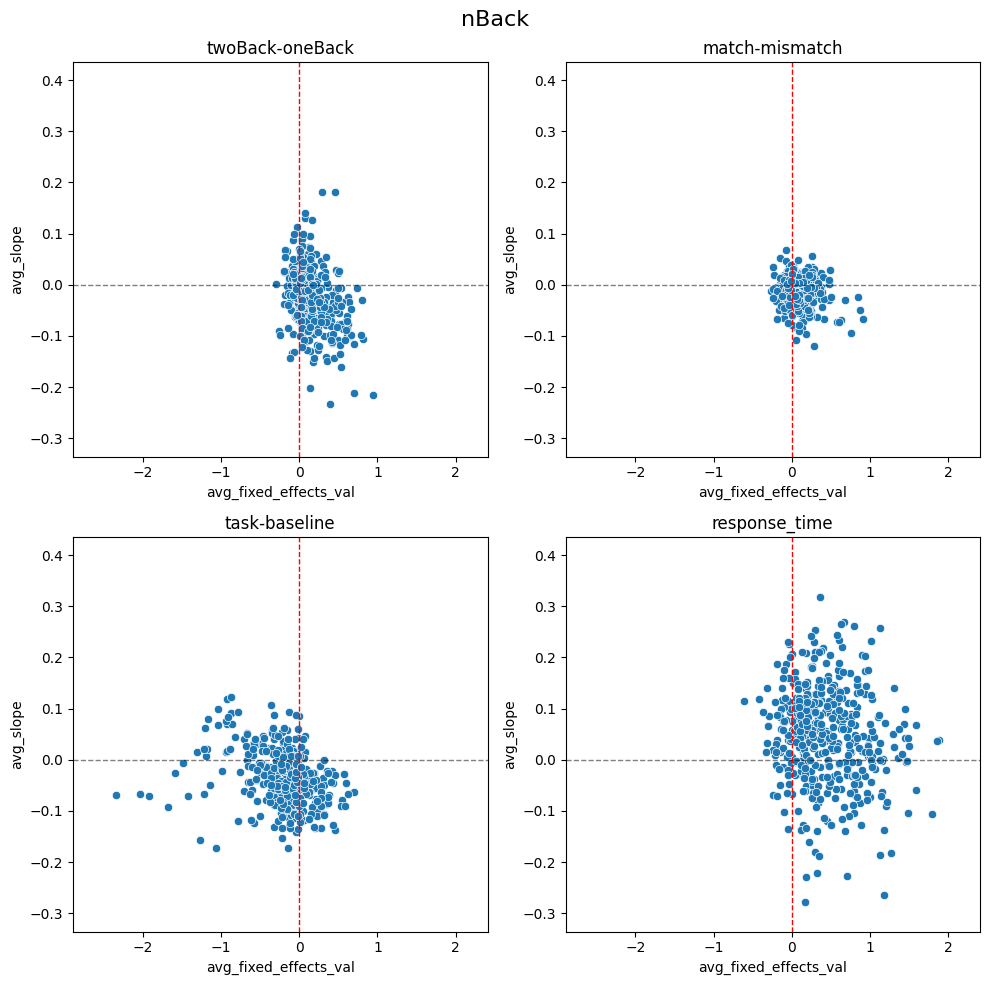

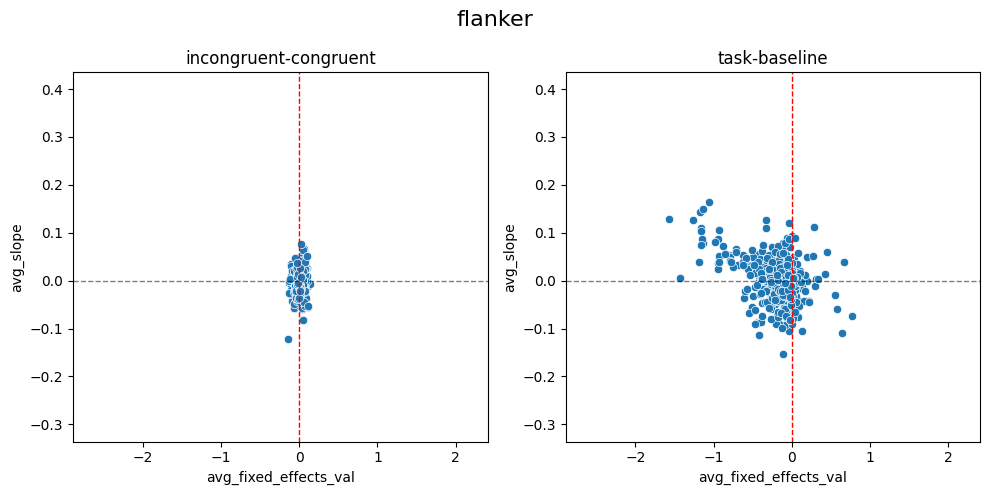

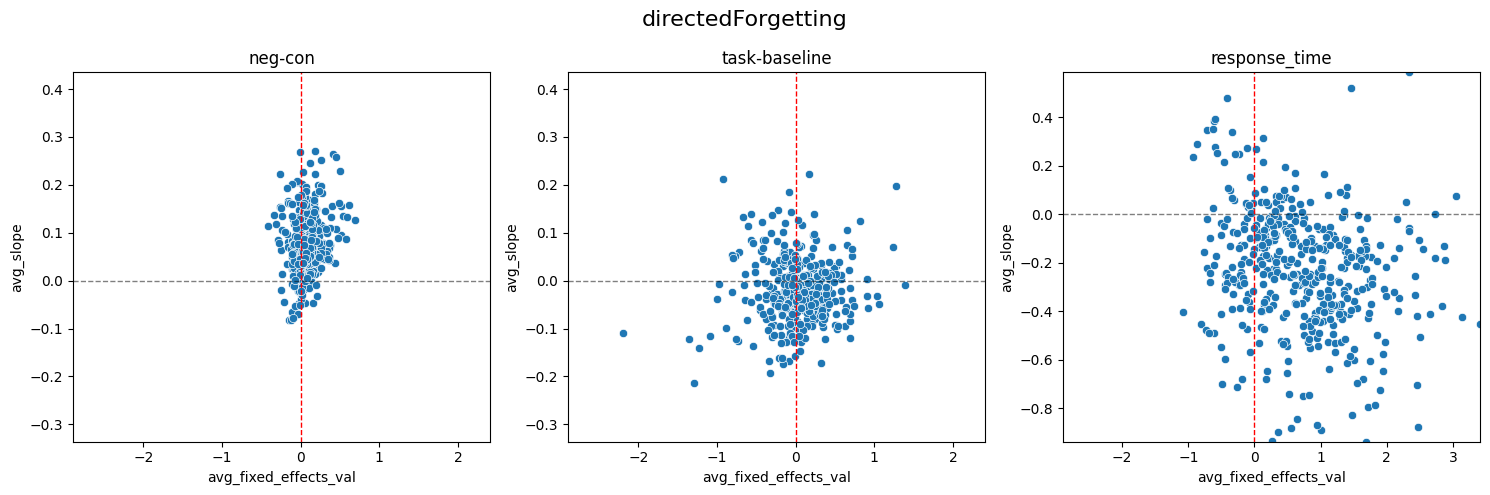

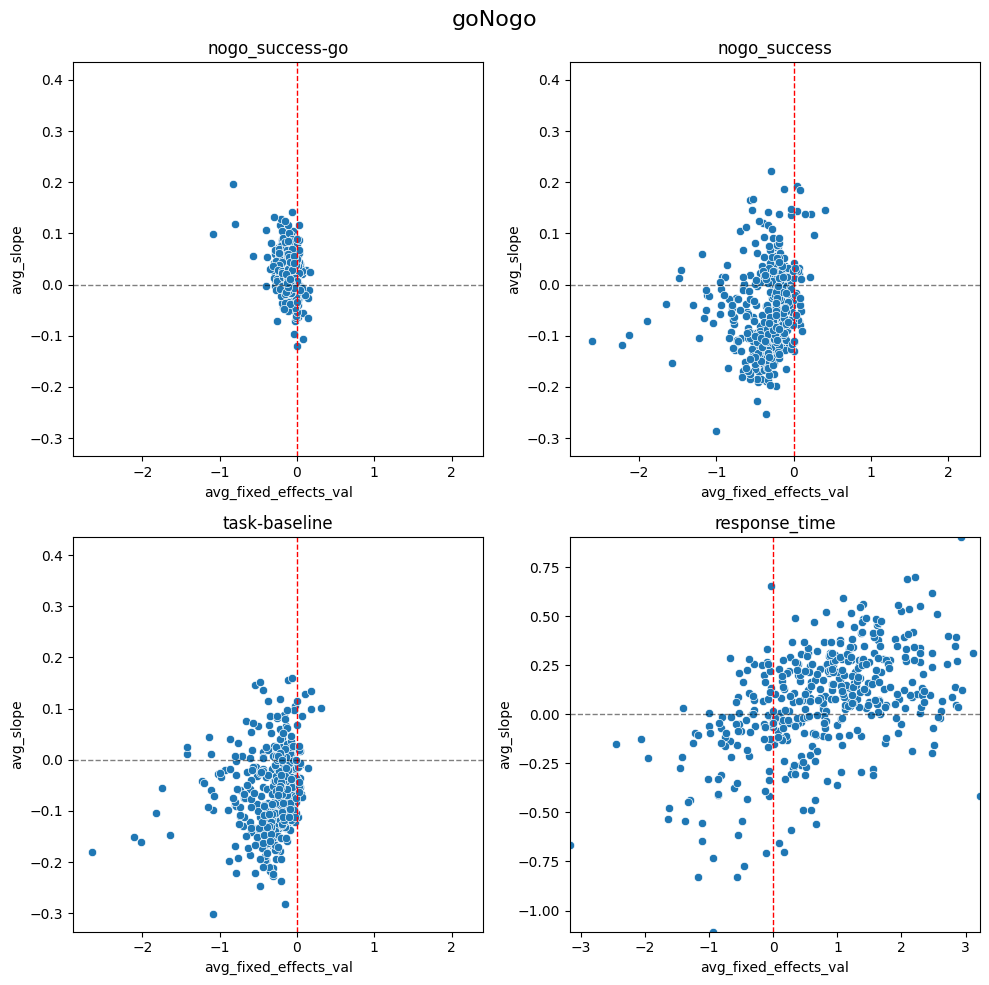

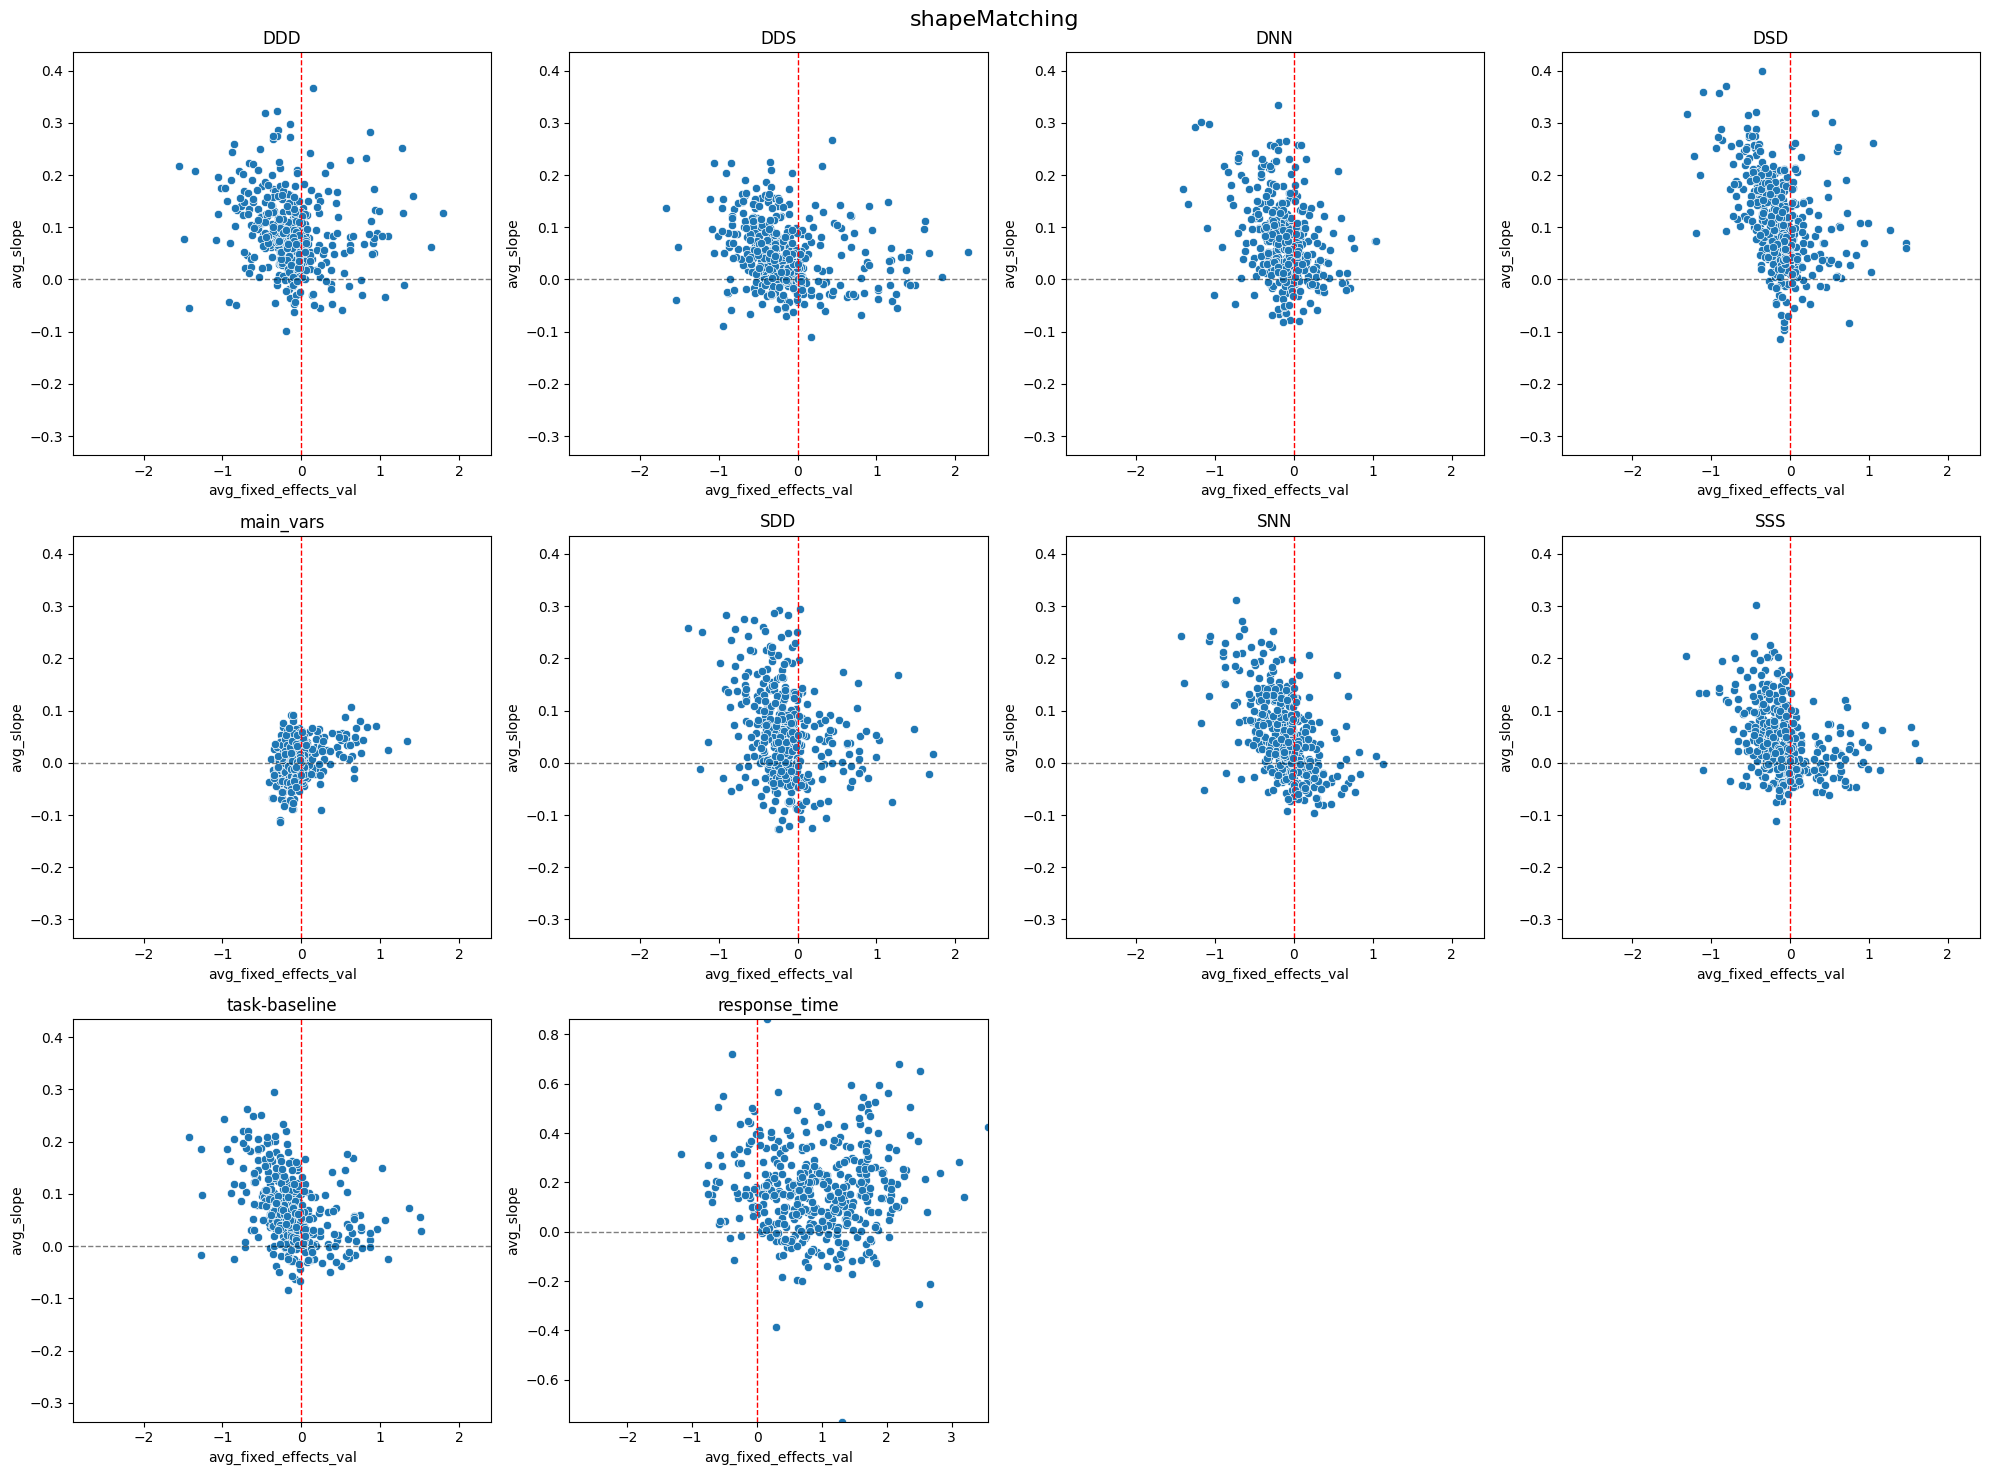

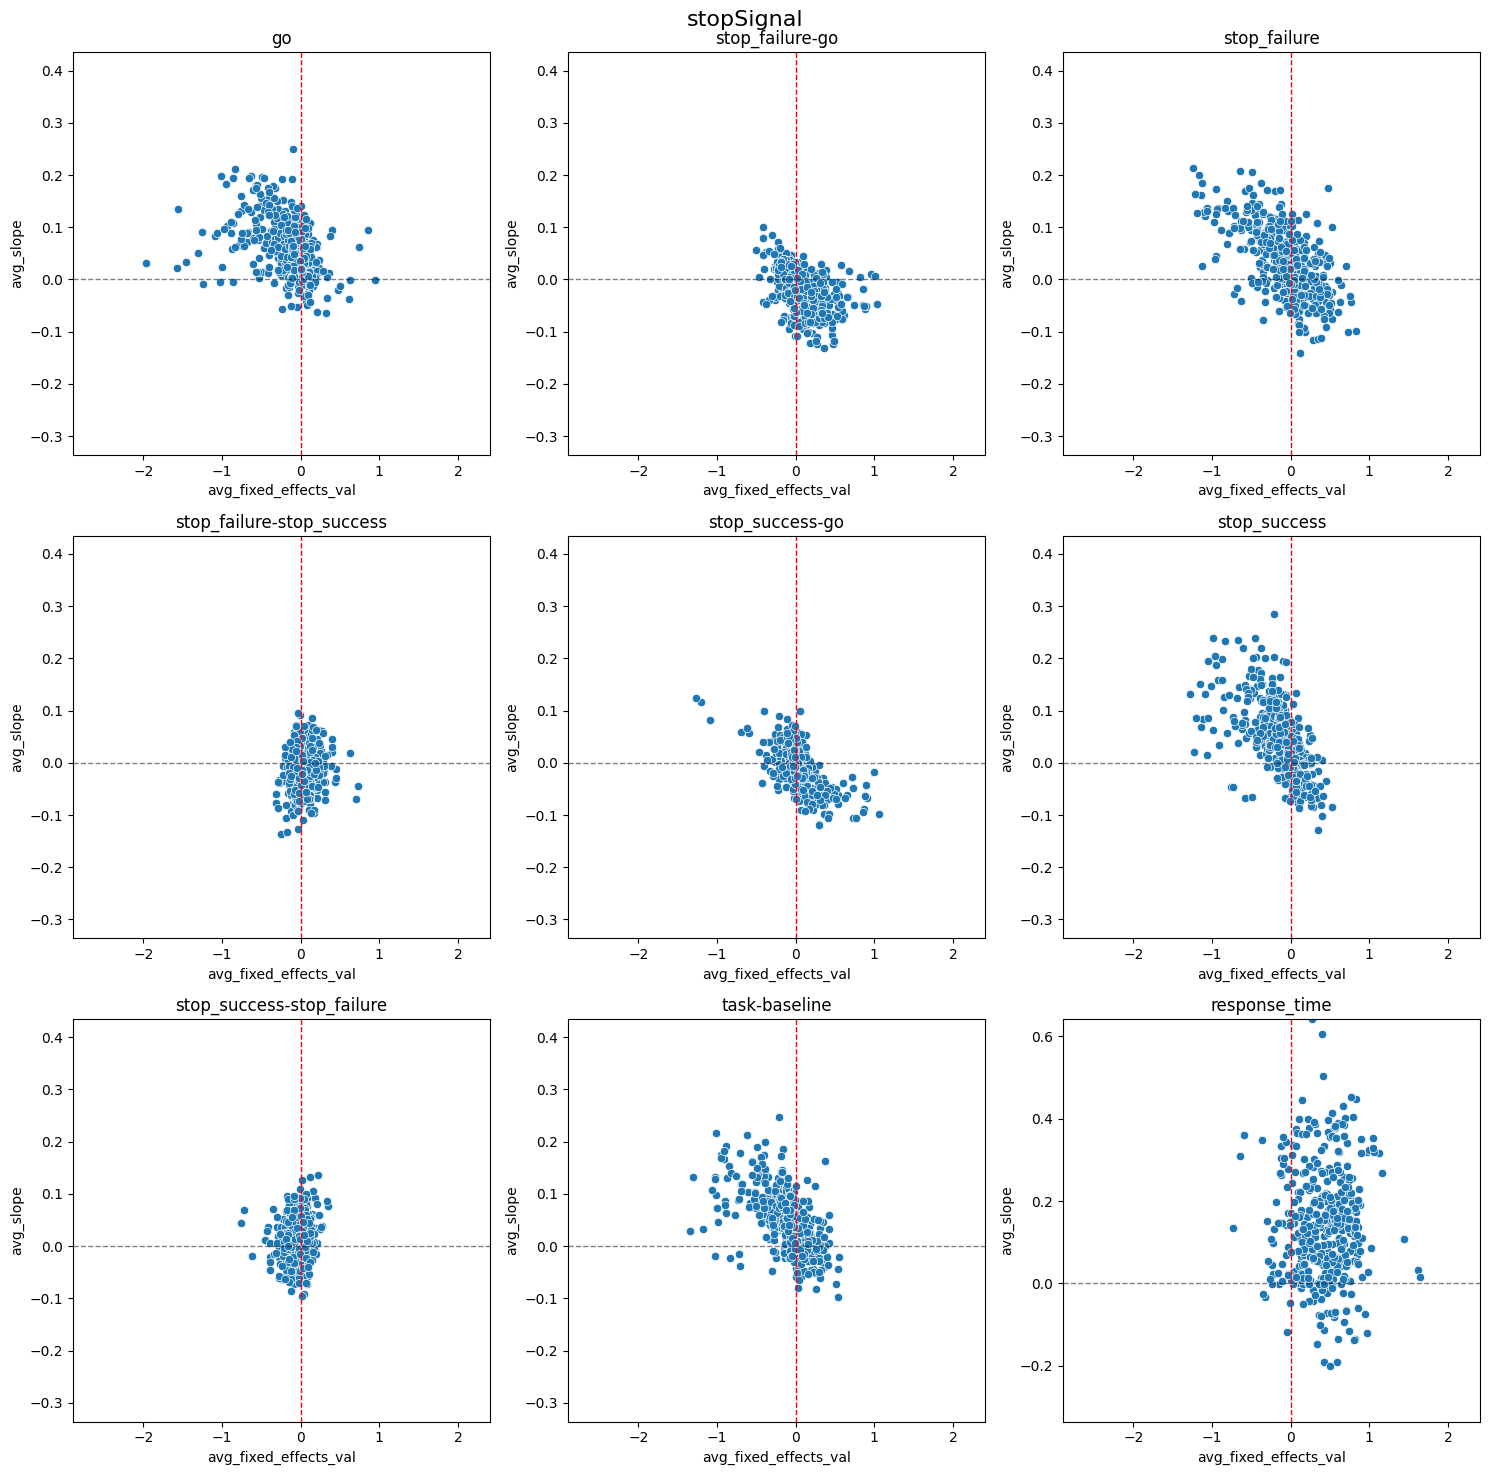

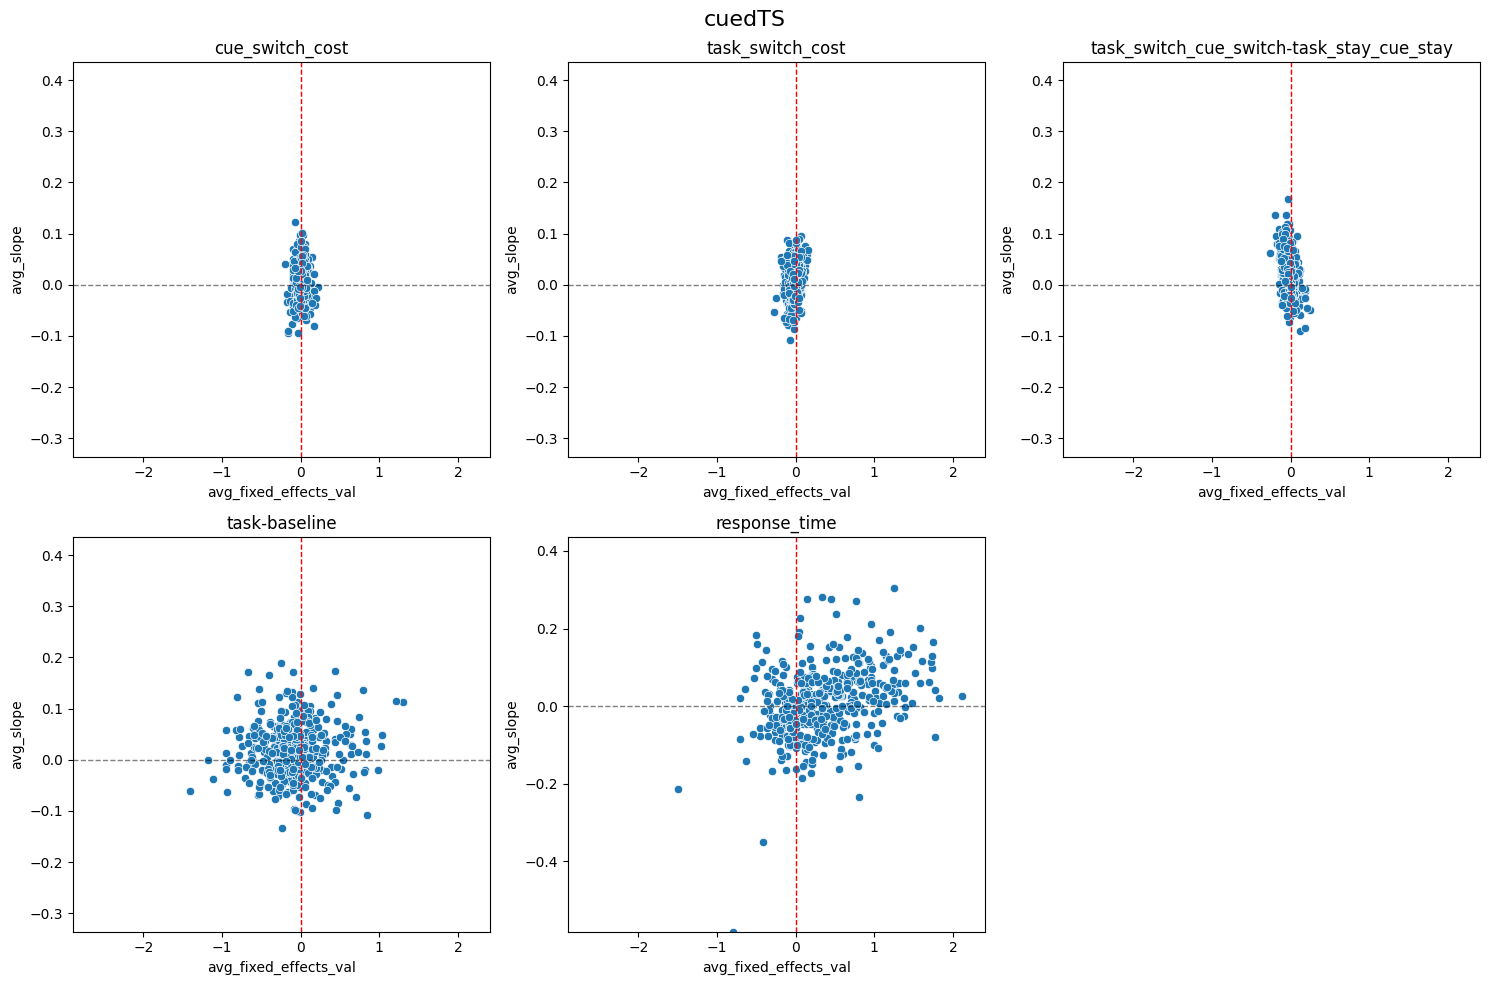

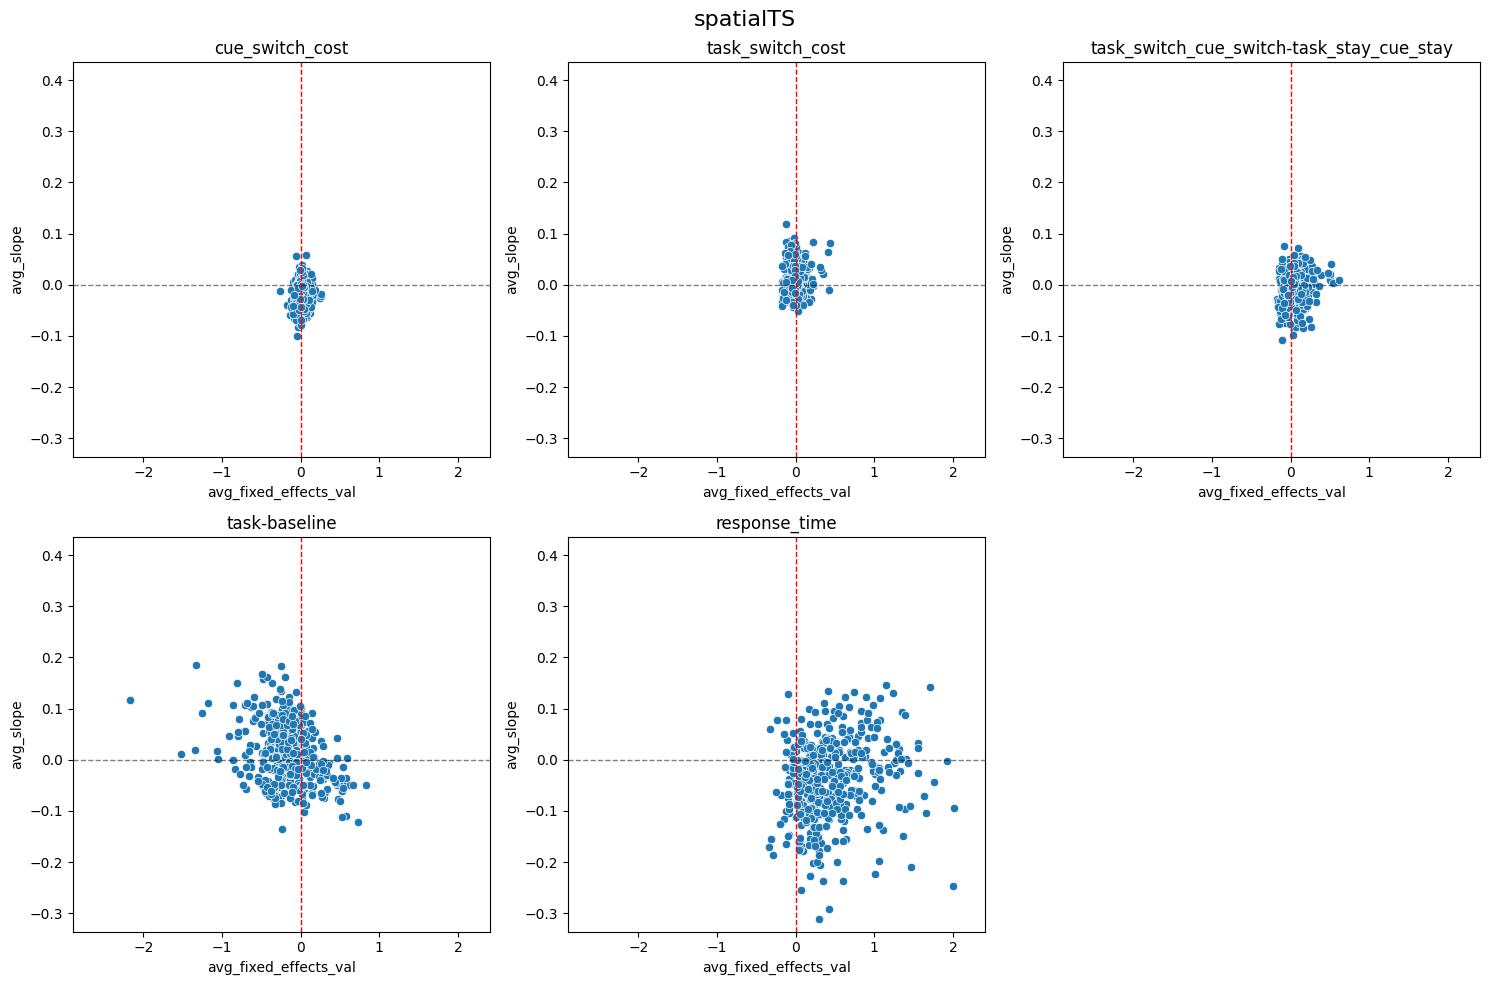

In [14]:
for task in avg_activations.keys():
    contrasts = list(avg_activations[task].keys())
    n_contrasts = len(contrasts)
    
    if n_contrasts <= 3:
        n_rows, n_cols = 1, n_contrasts
    elif n_contrasts <= 6:
        n_rows = 2
        n_cols = int(np.ceil(n_contrasts / 2))
    else:
        n_rows = 3
        n_cols = int(np.ceil(n_contrasts / 3))
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    
    # Flatten axes array for easier indexing
    if n_contrasts == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, contrast in enumerate(contrasts):
        sns.scatterplot(data=avg_activations[task][contrast], 
                       x="avg_fixed_effects_val", 
                       y="avg_slope", 
                       ax=axes[idx])
        axes[idx].axvline(x=0, color='red', linestyle='--', linewidth=1)
        axes[idx].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        axes[idx].set_title(f"{contrast}")

        if (contrast != "response_time"):
            axes[idx].set_xlim(x_min, x_max)
            axes[idx].set_ylim(y_min, y_max)
        else: 
            rt_max_x = max(x_max, np.max(avg_activations[task][contrast]["avg_fixed_effects_val"]))
            rt_max_y = max(y_max, np.max(avg_activations[task][contrast]["avg_slope"]))
            rt_min_x = min(x_min, np.min(avg_activations[task][contrast]["avg_fixed_effects_val"]))
            rt_min_y = min(y_min, np.min(avg_activations[task][contrast]["avg_slope"]))
            axes[idx].set_xlim(rt_min_x, rt_max_x)
            axes[idx].set_ylim(rt_min_y, rt_max_y)
    
    # Hide any unused subplots
    for idx in range(n_contrasts, len(axes)):
        axes[idx].set_visible(False)
    
    fig.suptitle(f"{task}", fontsize=16)
    plt.tight_layout()
    plt.show()

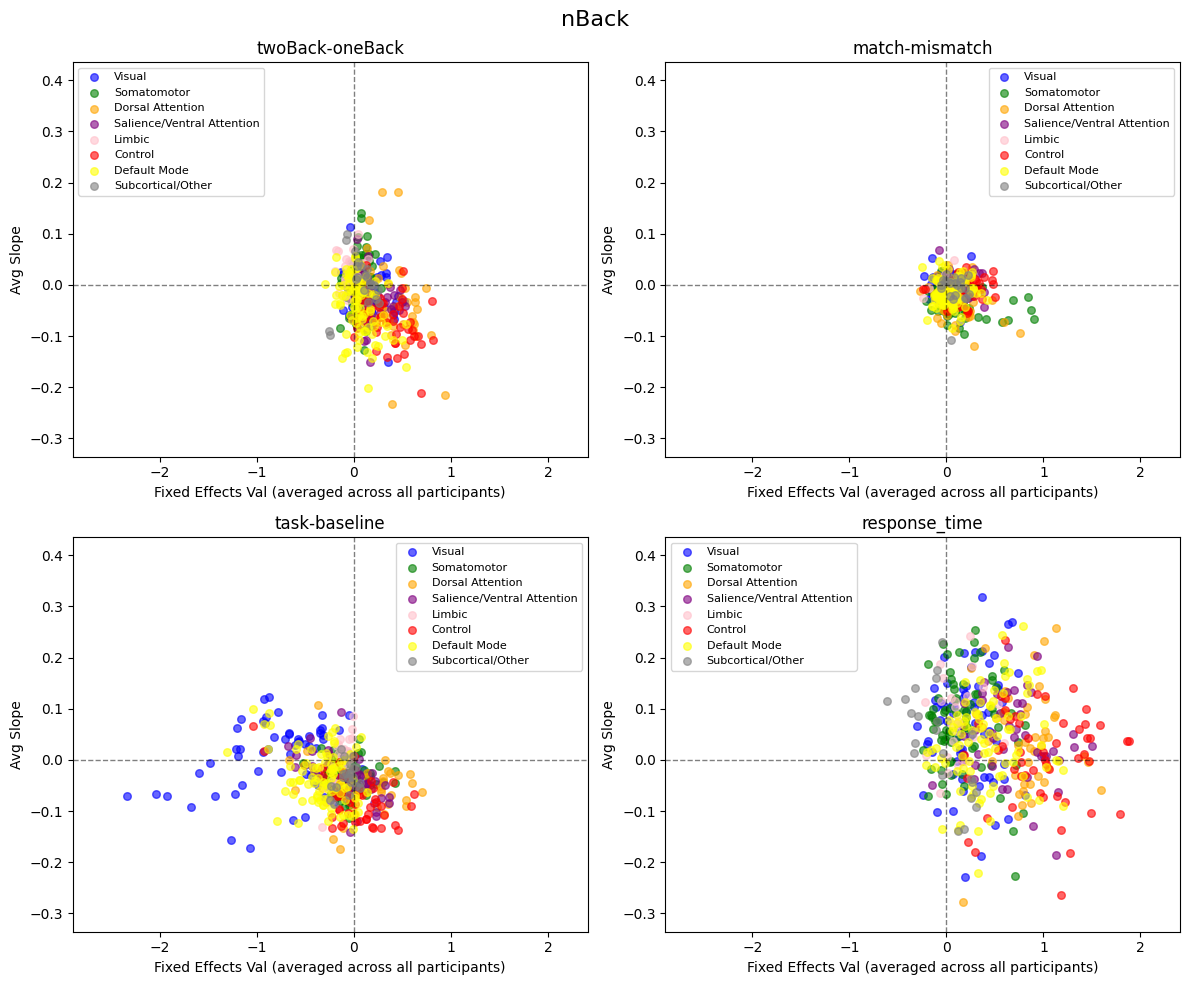

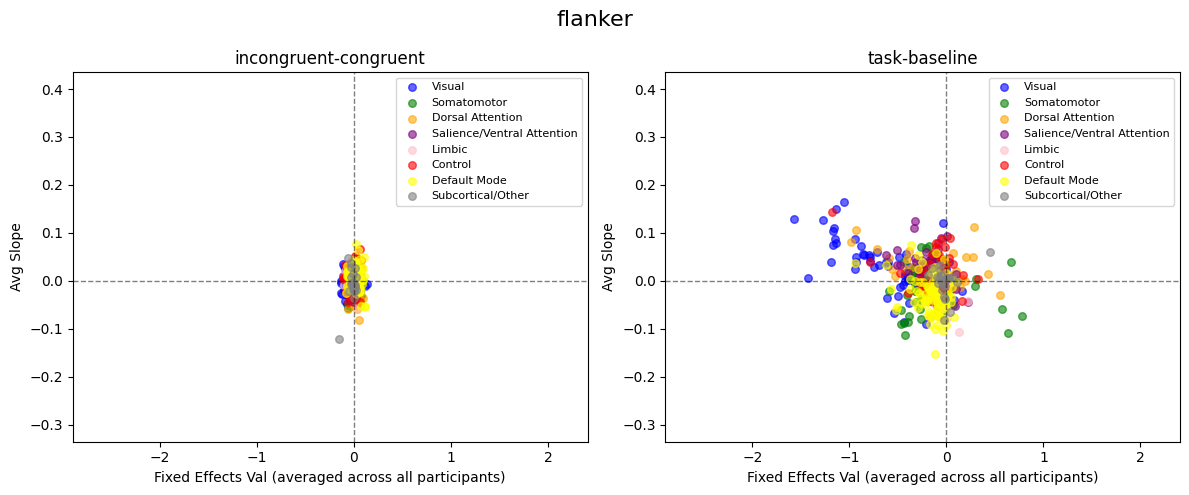

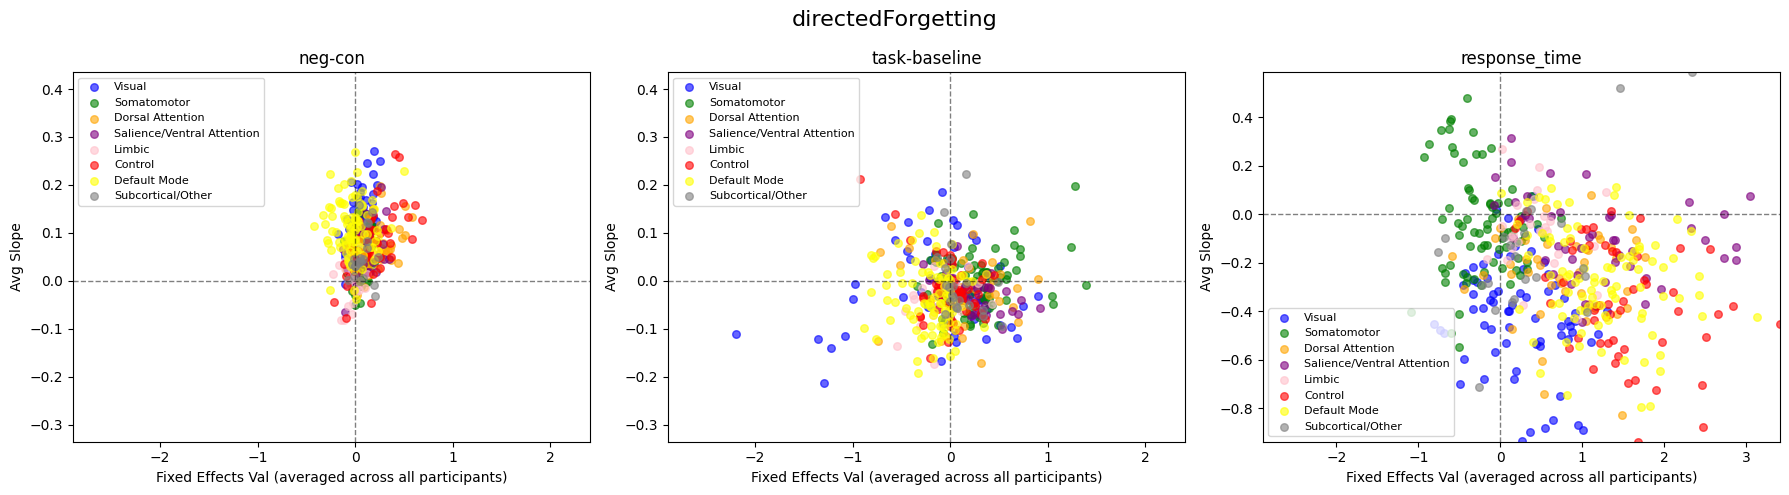

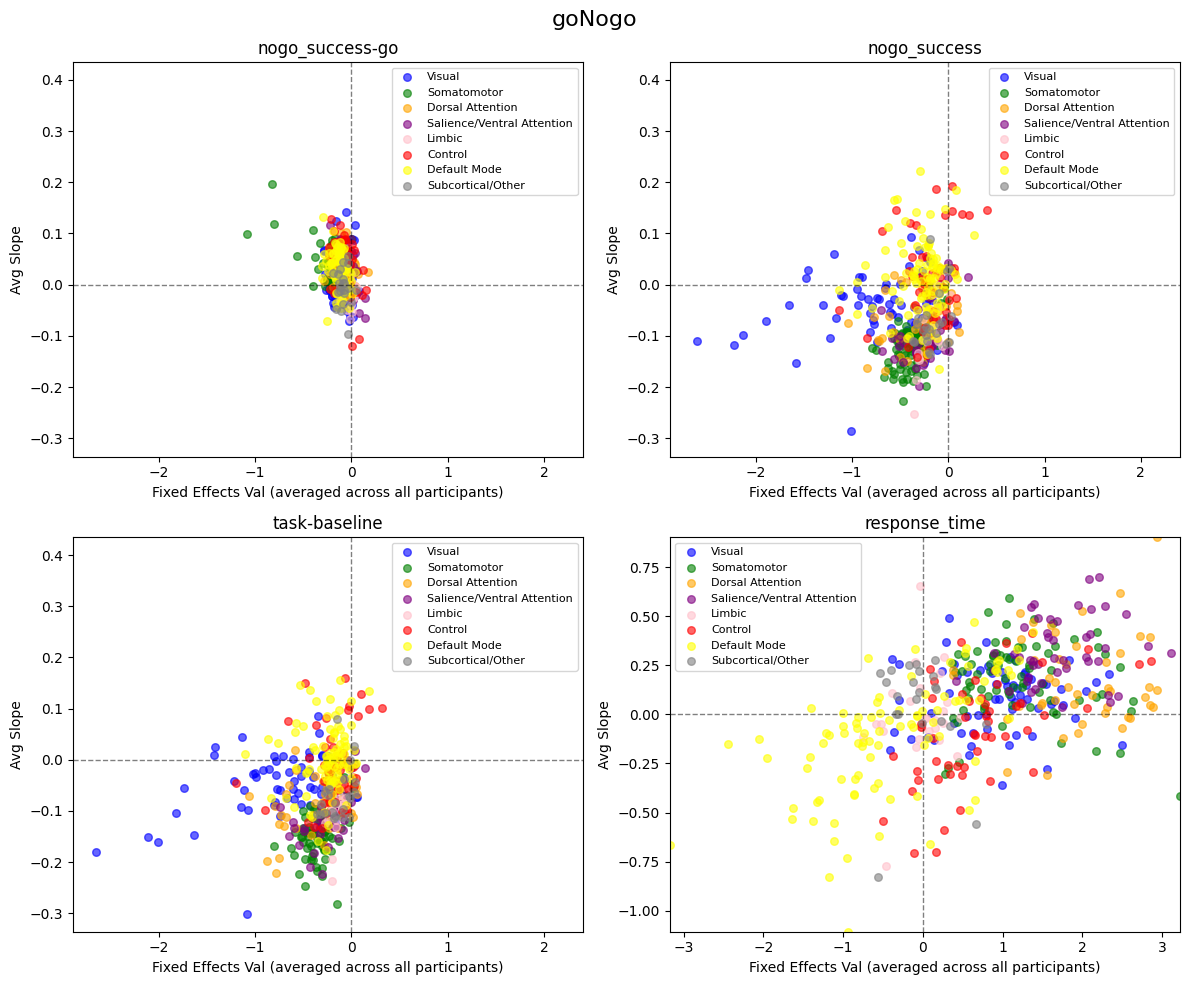

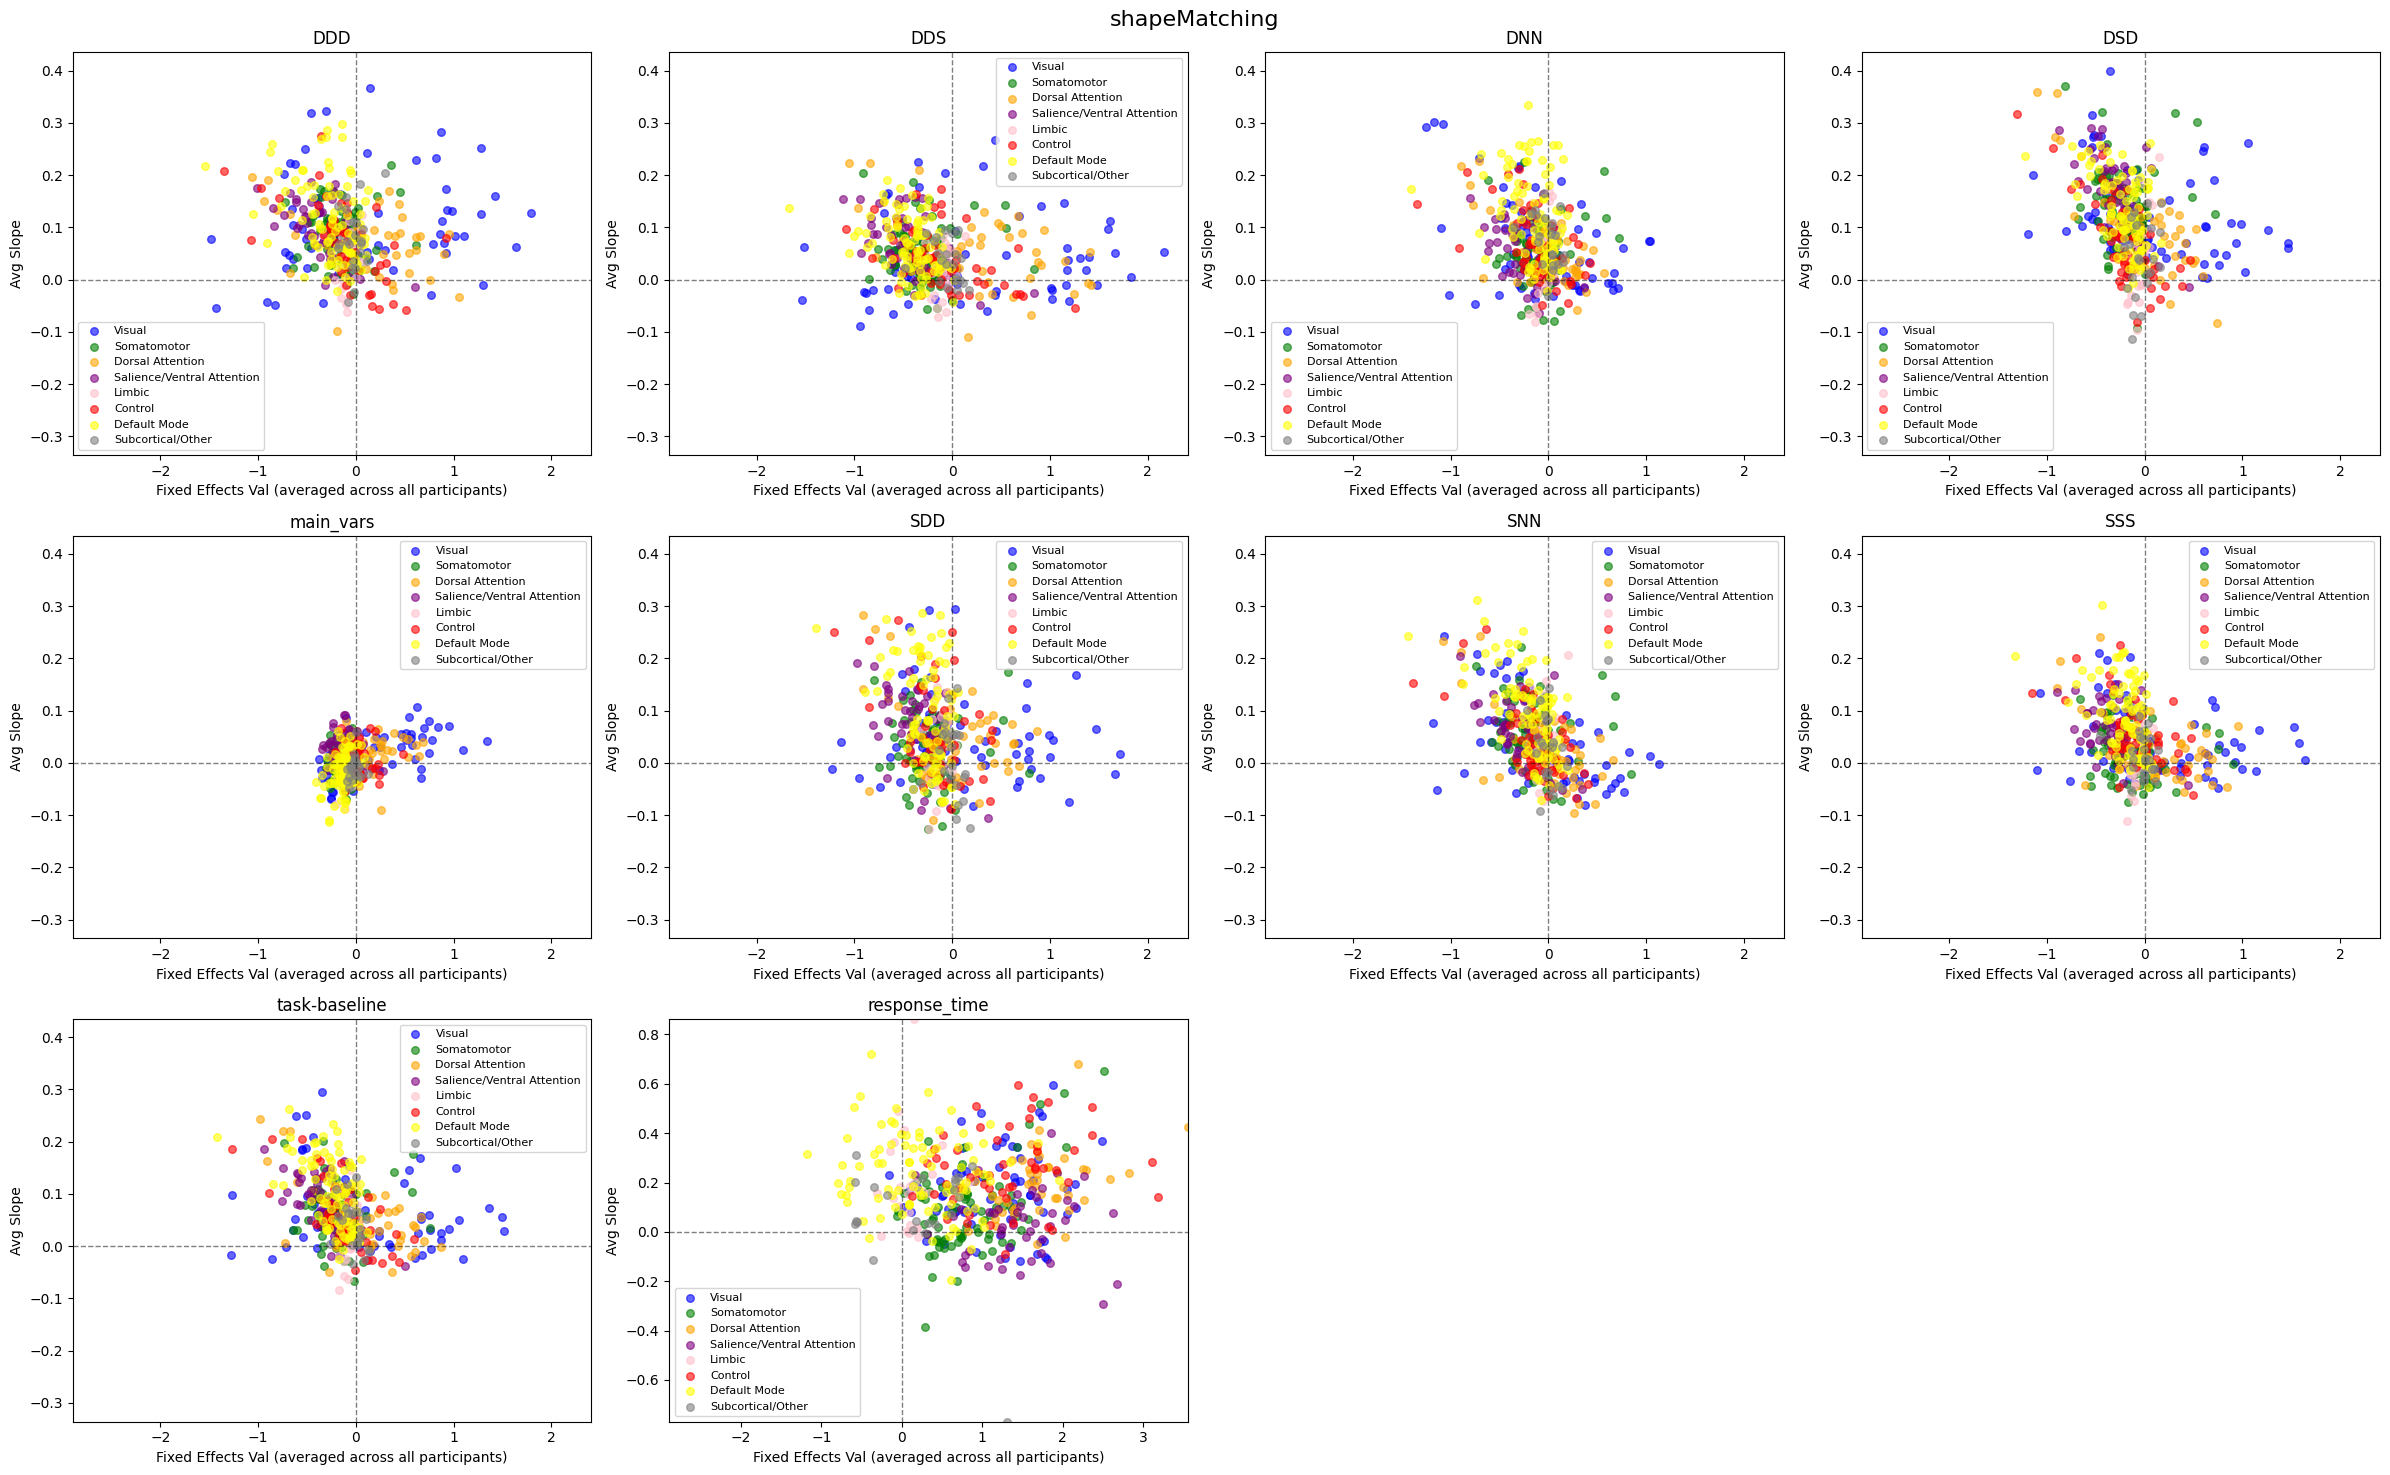

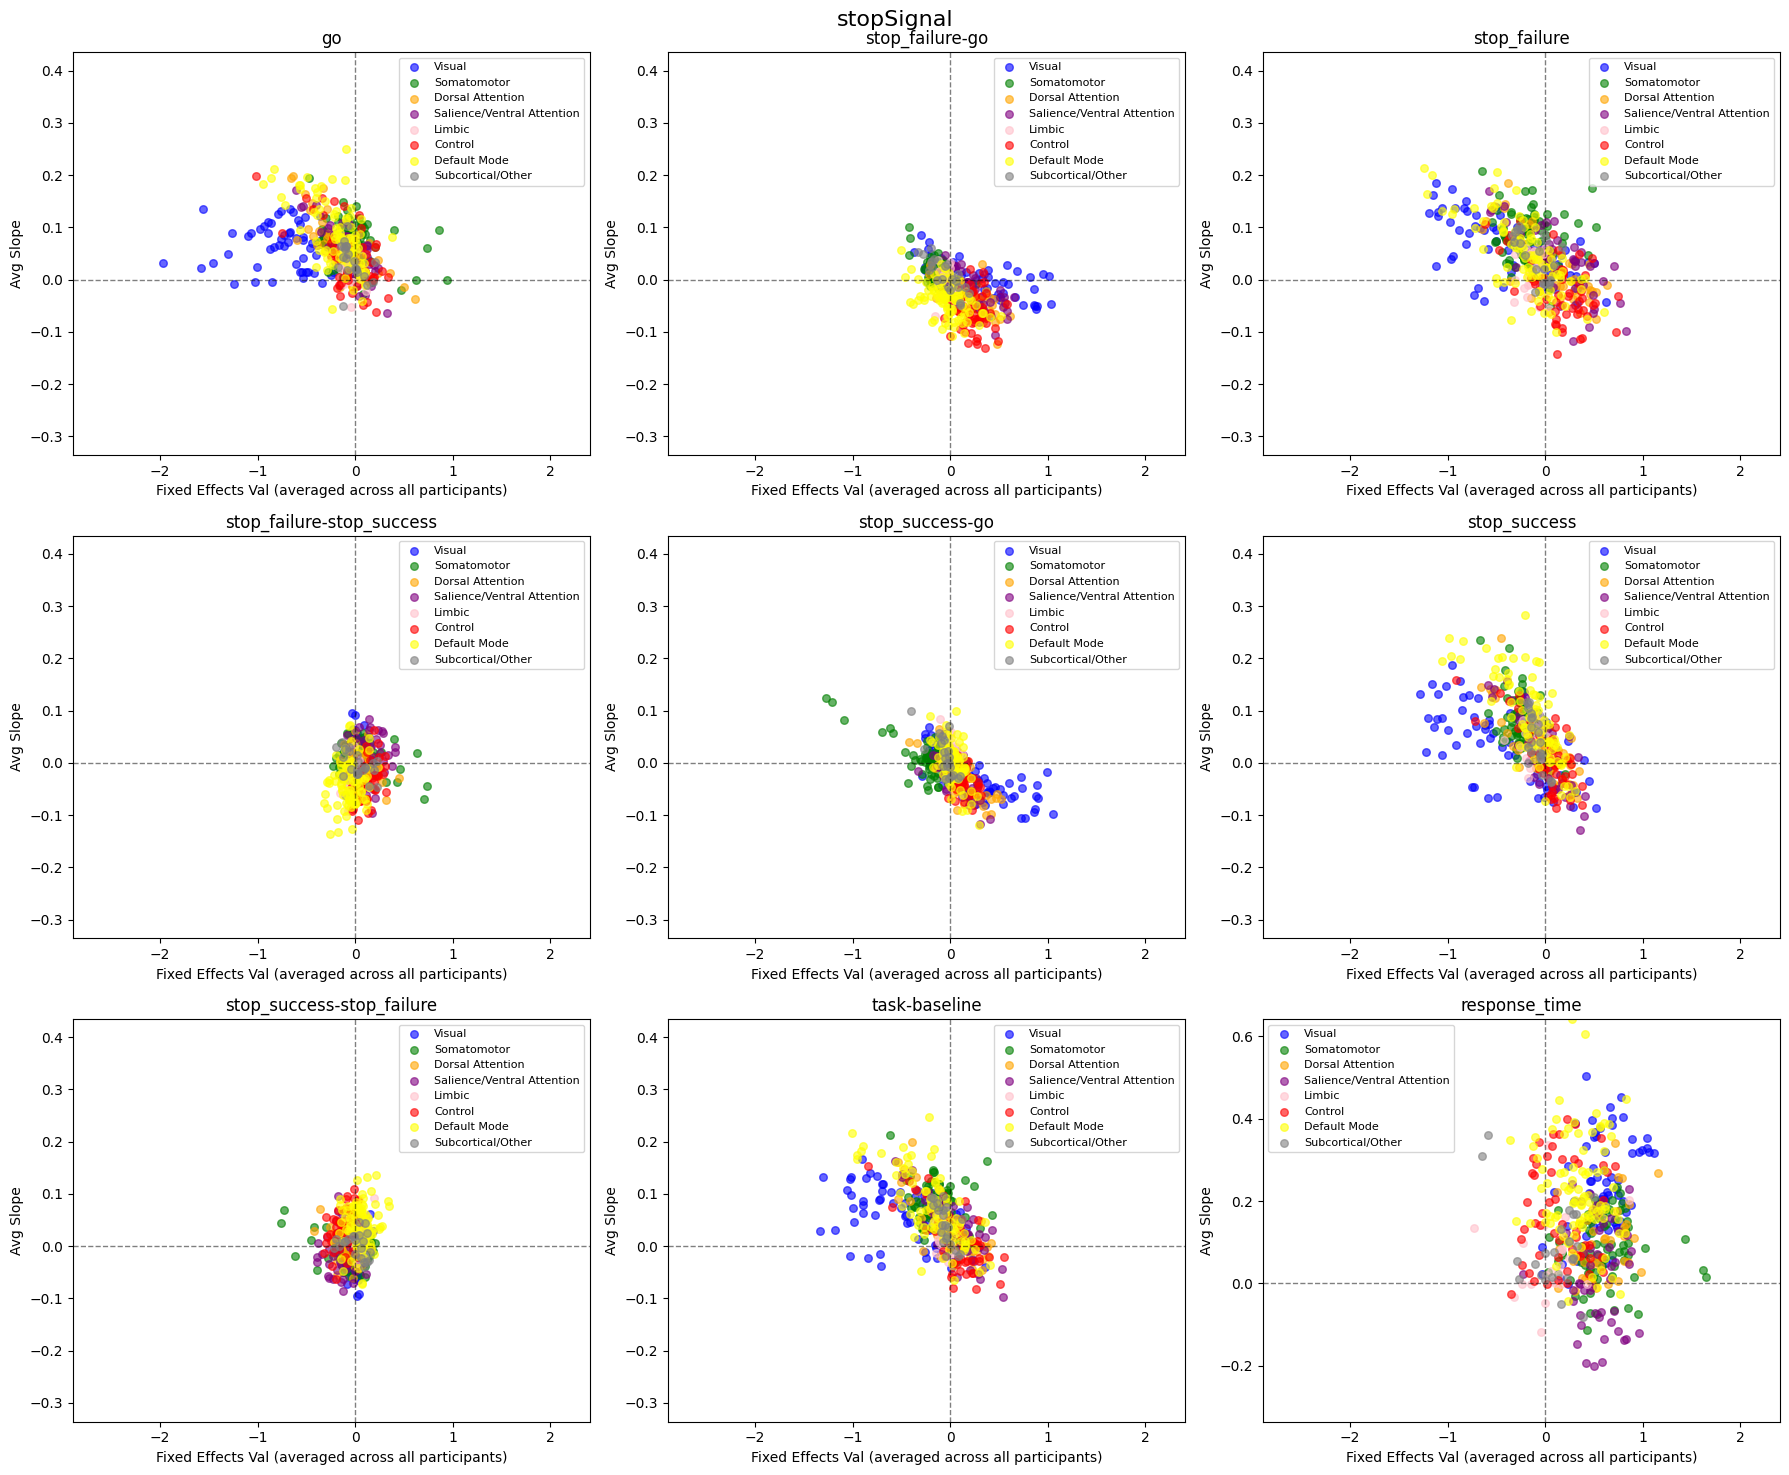

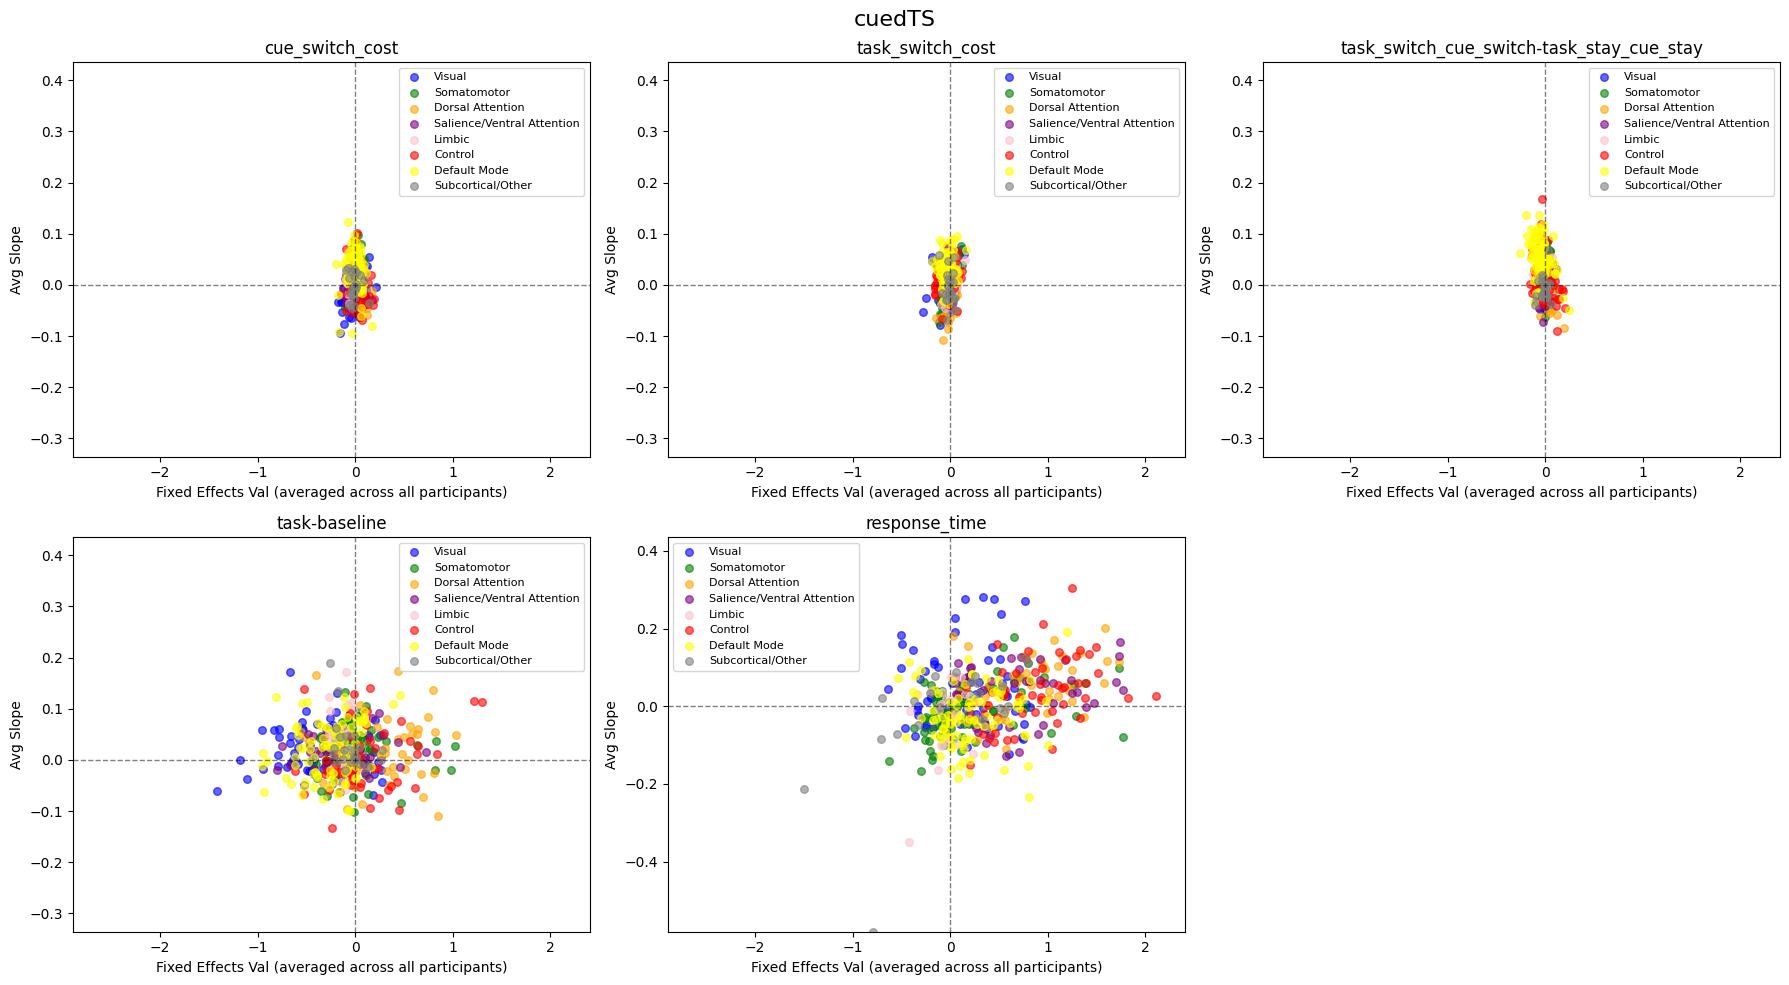

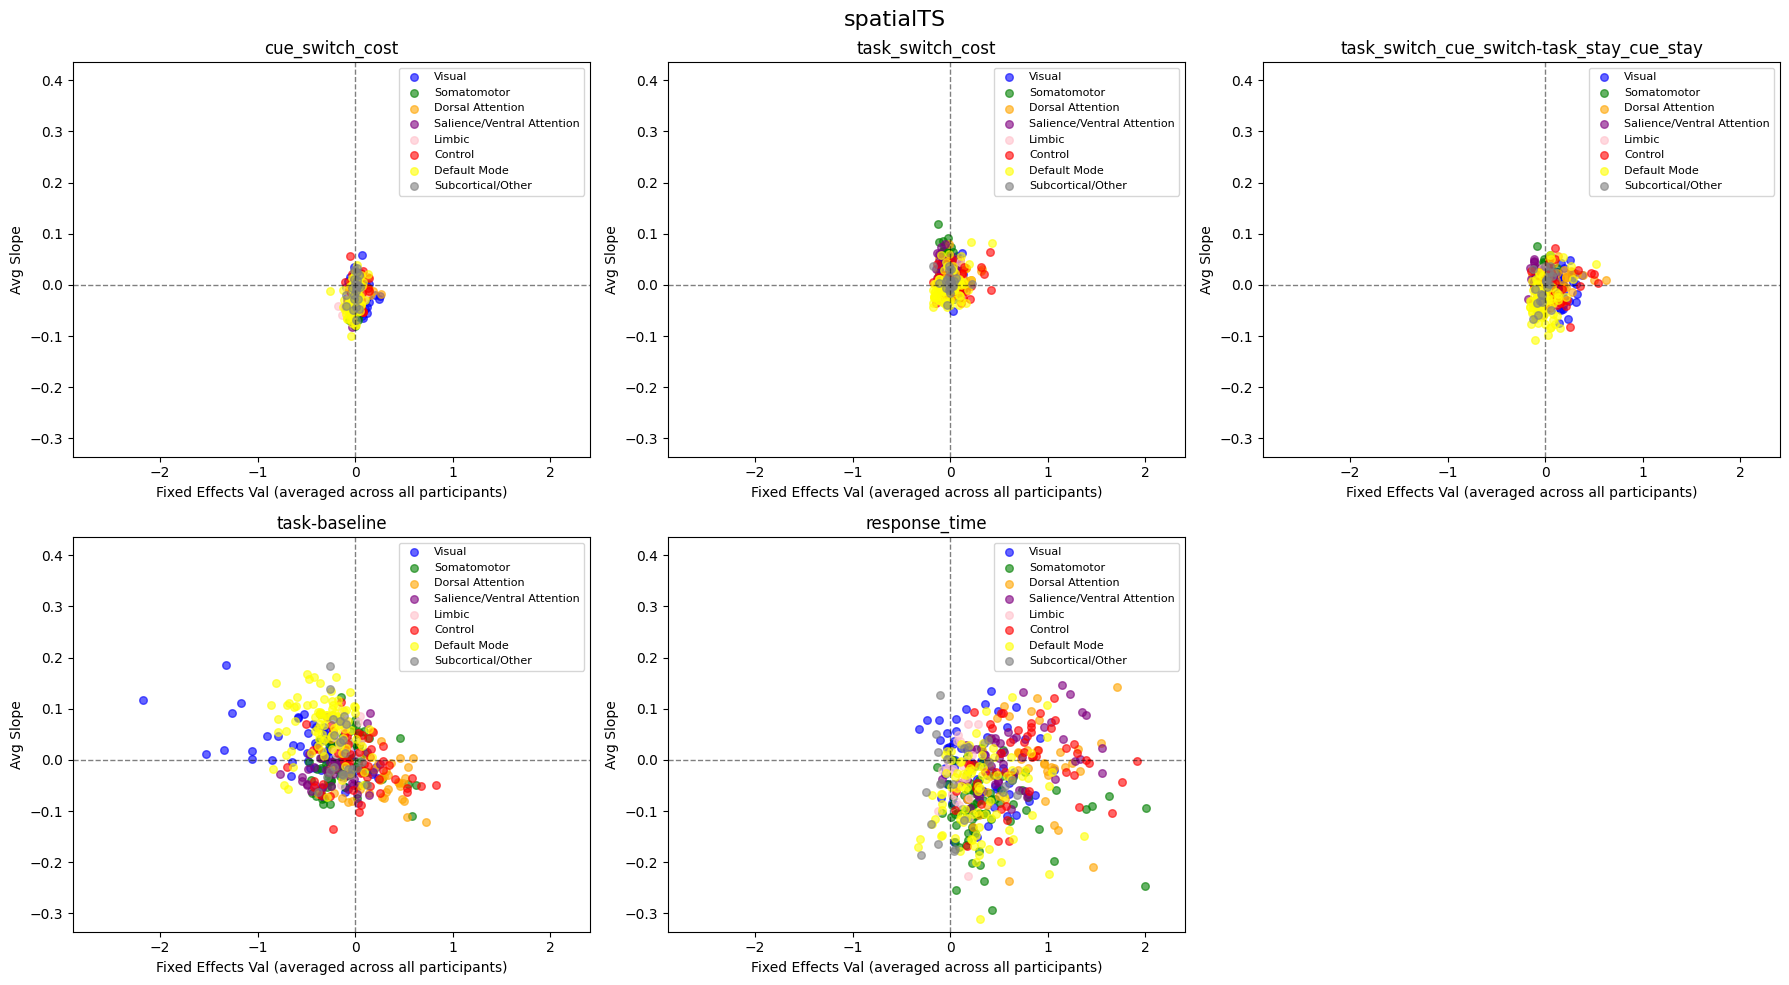

In [16]:
def get_network_category(parcel_name):
    if 'Vis' in parcel_name:
        return 'Visual'
    elif 'SomMot' in parcel_name:
        return 'Somatomotor'
    elif 'DorsAttn' in parcel_name:
        return 'Dorsal Attention'
    elif 'SalVentAttn' in parcel_name:
        return 'Salience/Ventral Attention'
    elif 'Limbic' in parcel_name:
        return 'Limbic'
    elif 'Cont' in parcel_name:
        return 'Control'
    elif 'Default' in parcel_name:
        return 'Default Mode'
    else:
        return 'Subcortical/Other'

# Create color mapping
network_colors = {
    'Visual': 'blue',
    'Somatomotor': 'green',
    'Dorsal Attention': 'orange',
    'Salience/Ventral Attention': 'purple',
    'Limbic': 'pink',
    'Control': 'red',
    'Default Mode': 'yellow',
    'Subcortical/Other': 'gray'
}

for task in avg_activations.keys():
    contrasts = list(avg_activations[task].keys())
    n_contrasts = len(contrasts)
    
    if n_contrasts <= 3:
        n_rows, n_cols = 1, n_contrasts
    elif n_contrasts <= 6:
        n_rows = 2
        n_cols = int(np.ceil(n_contrasts / 2))
    else:
        n_rows = 3
        n_cols = int(np.ceil(n_contrasts / 3))
    
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    
    if n_contrasts == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, contrast in enumerate(contrasts):
        # Get network categories for each parcel
        parcels = list(avg_parcel_traj_results[task][contrast].keys())
        network_categories = [get_network_category(p) for p in parcels]
        
        # Plot each network separately for legend
        for network in network_colors.keys():
            mask = [cat == network for cat in network_categories]
            if any(mask):
                x_vals = [avg_activations[task][contrast]["avg_fixed_effects_val"][i] 
                         for i, m in enumerate(mask) if m]
                y_vals = [avg_activations[task][contrast]["avg_slope"][i] 
                         for i, m in enumerate(mask) if m]
                
                axes[idx].scatter(x_vals, y_vals, 
                                c=network_colors[network], 
                                label=network, 
                                alpha=0.6, 
                                s=30)
        
        axes[idx].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        axes[idx].axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        axes[idx].set_title(f"{contrast}")
        axes[idx].set_xlabel("Fixed Effects Val (averaged across all participants)")
        axes[idx].set_ylabel("Avg Slope")
        axes[idx].legend(fontsize=8, loc='best')
        if (contrast != "response_time"):
            axes[idx].set_xlim(x_min, x_max)
            axes[idx].set_ylim(y_min, y_max)
        else: 
            rt_max_x = max(x_max, np.max(avg_activations[task][contrast]["avg_fixed_effects_val"]))
            rt_max_y = max(y_max, np.max(avg_activations[task][contrast]["avg_slope"]))
            rt_min_x = min(x_min, np.min(avg_activations[task][contrast]["avg_fixed_effects_val"]))
            rt_min_y = min(y_min, np.min(avg_activations[task][contrast]["avg_slope"]))
            axes[idx].set_xlim(rt_min_x, rt_max_x)
            axes[idx].set_ylim(rt_min_y, rt_max_y)
    
    for idx in range(n_contrasts, len(axes)):
        axes[idx].set_visible(False)
    
    fig.suptitle(f"{task}", fontsize=16)
    plt.tight_layout()
    plt.show()

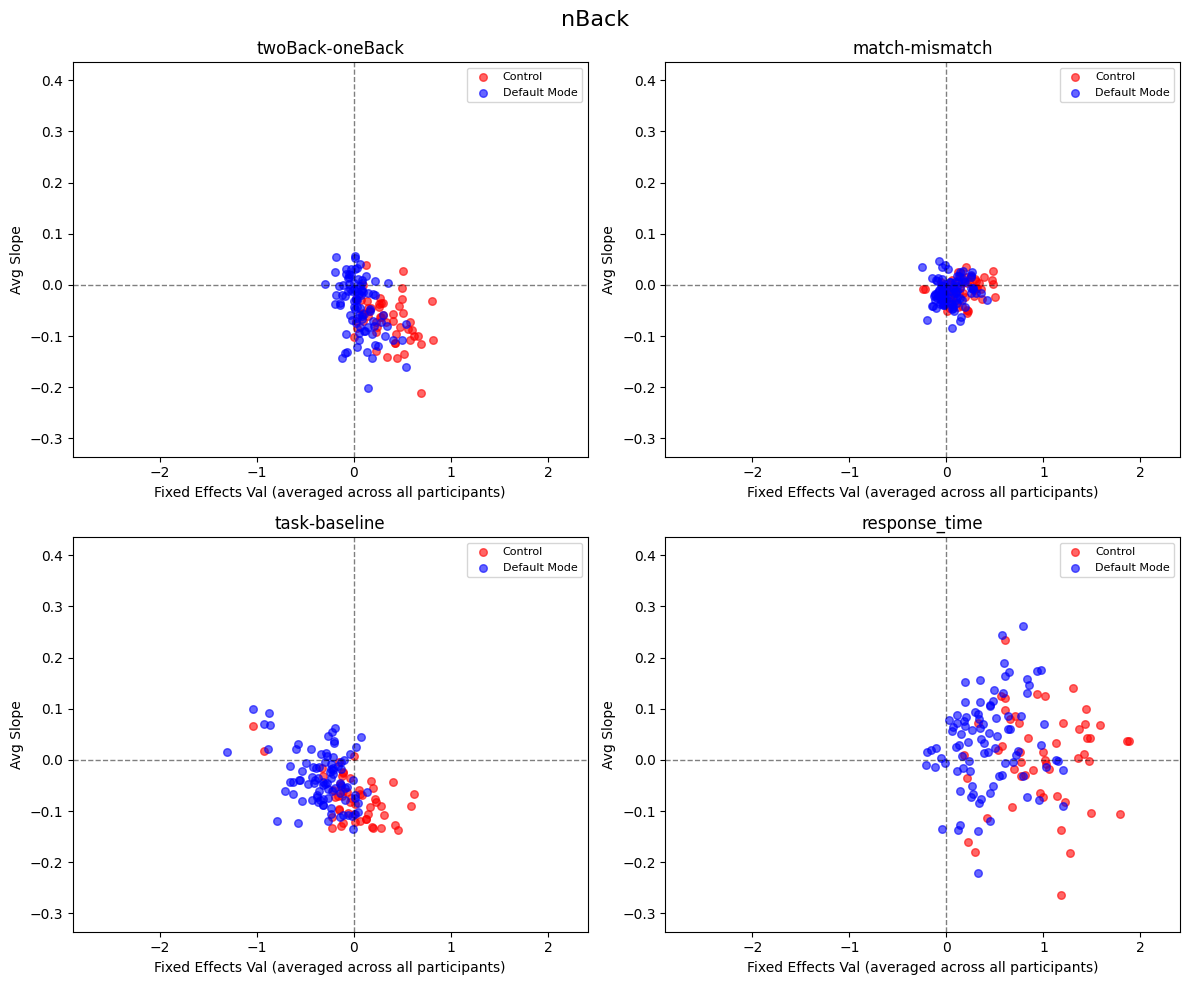

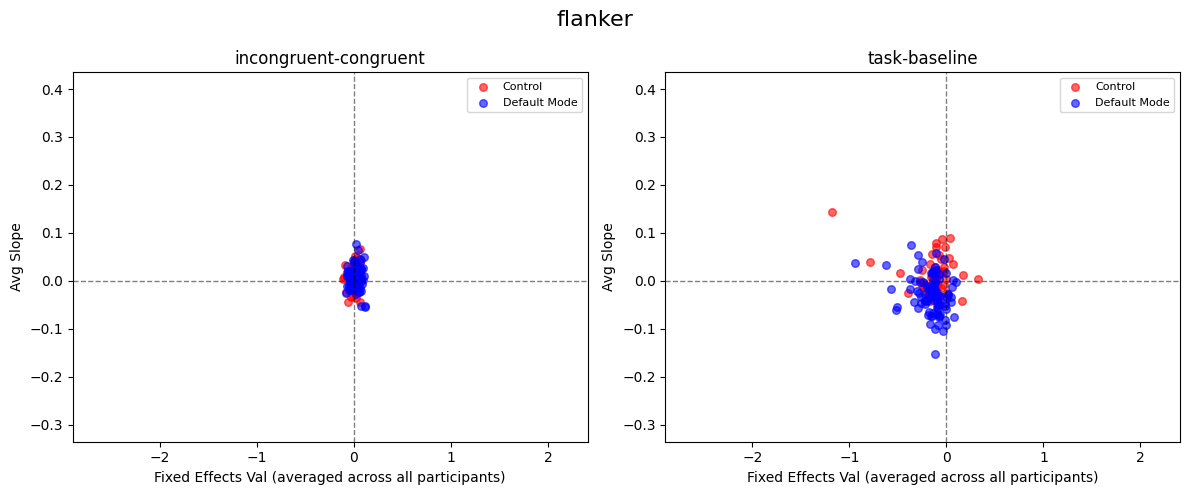

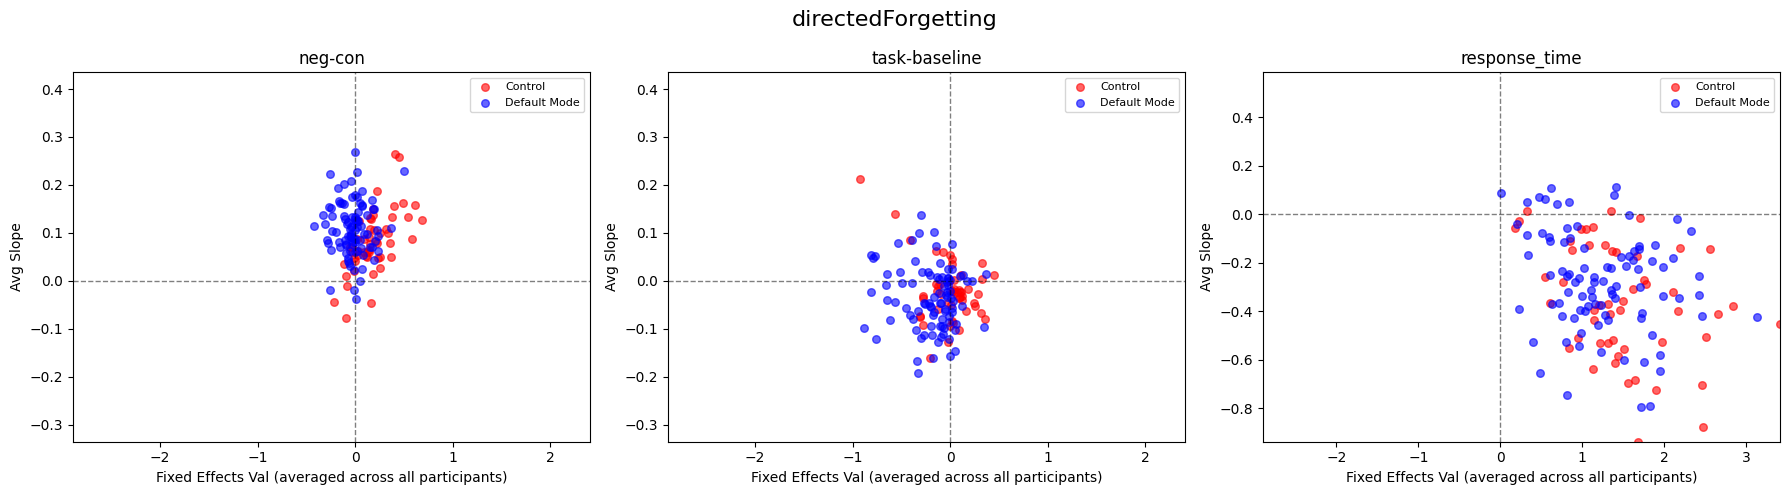

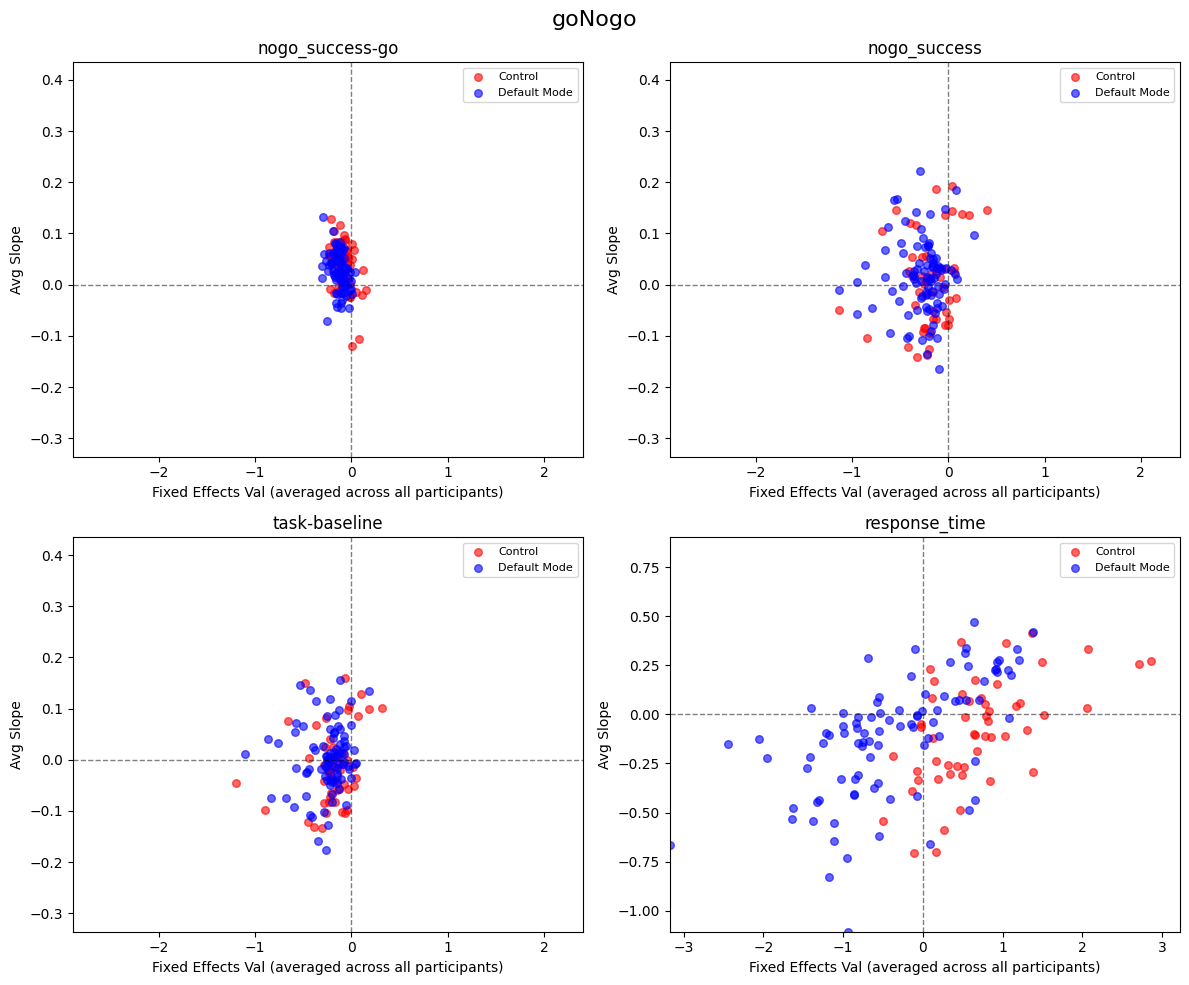

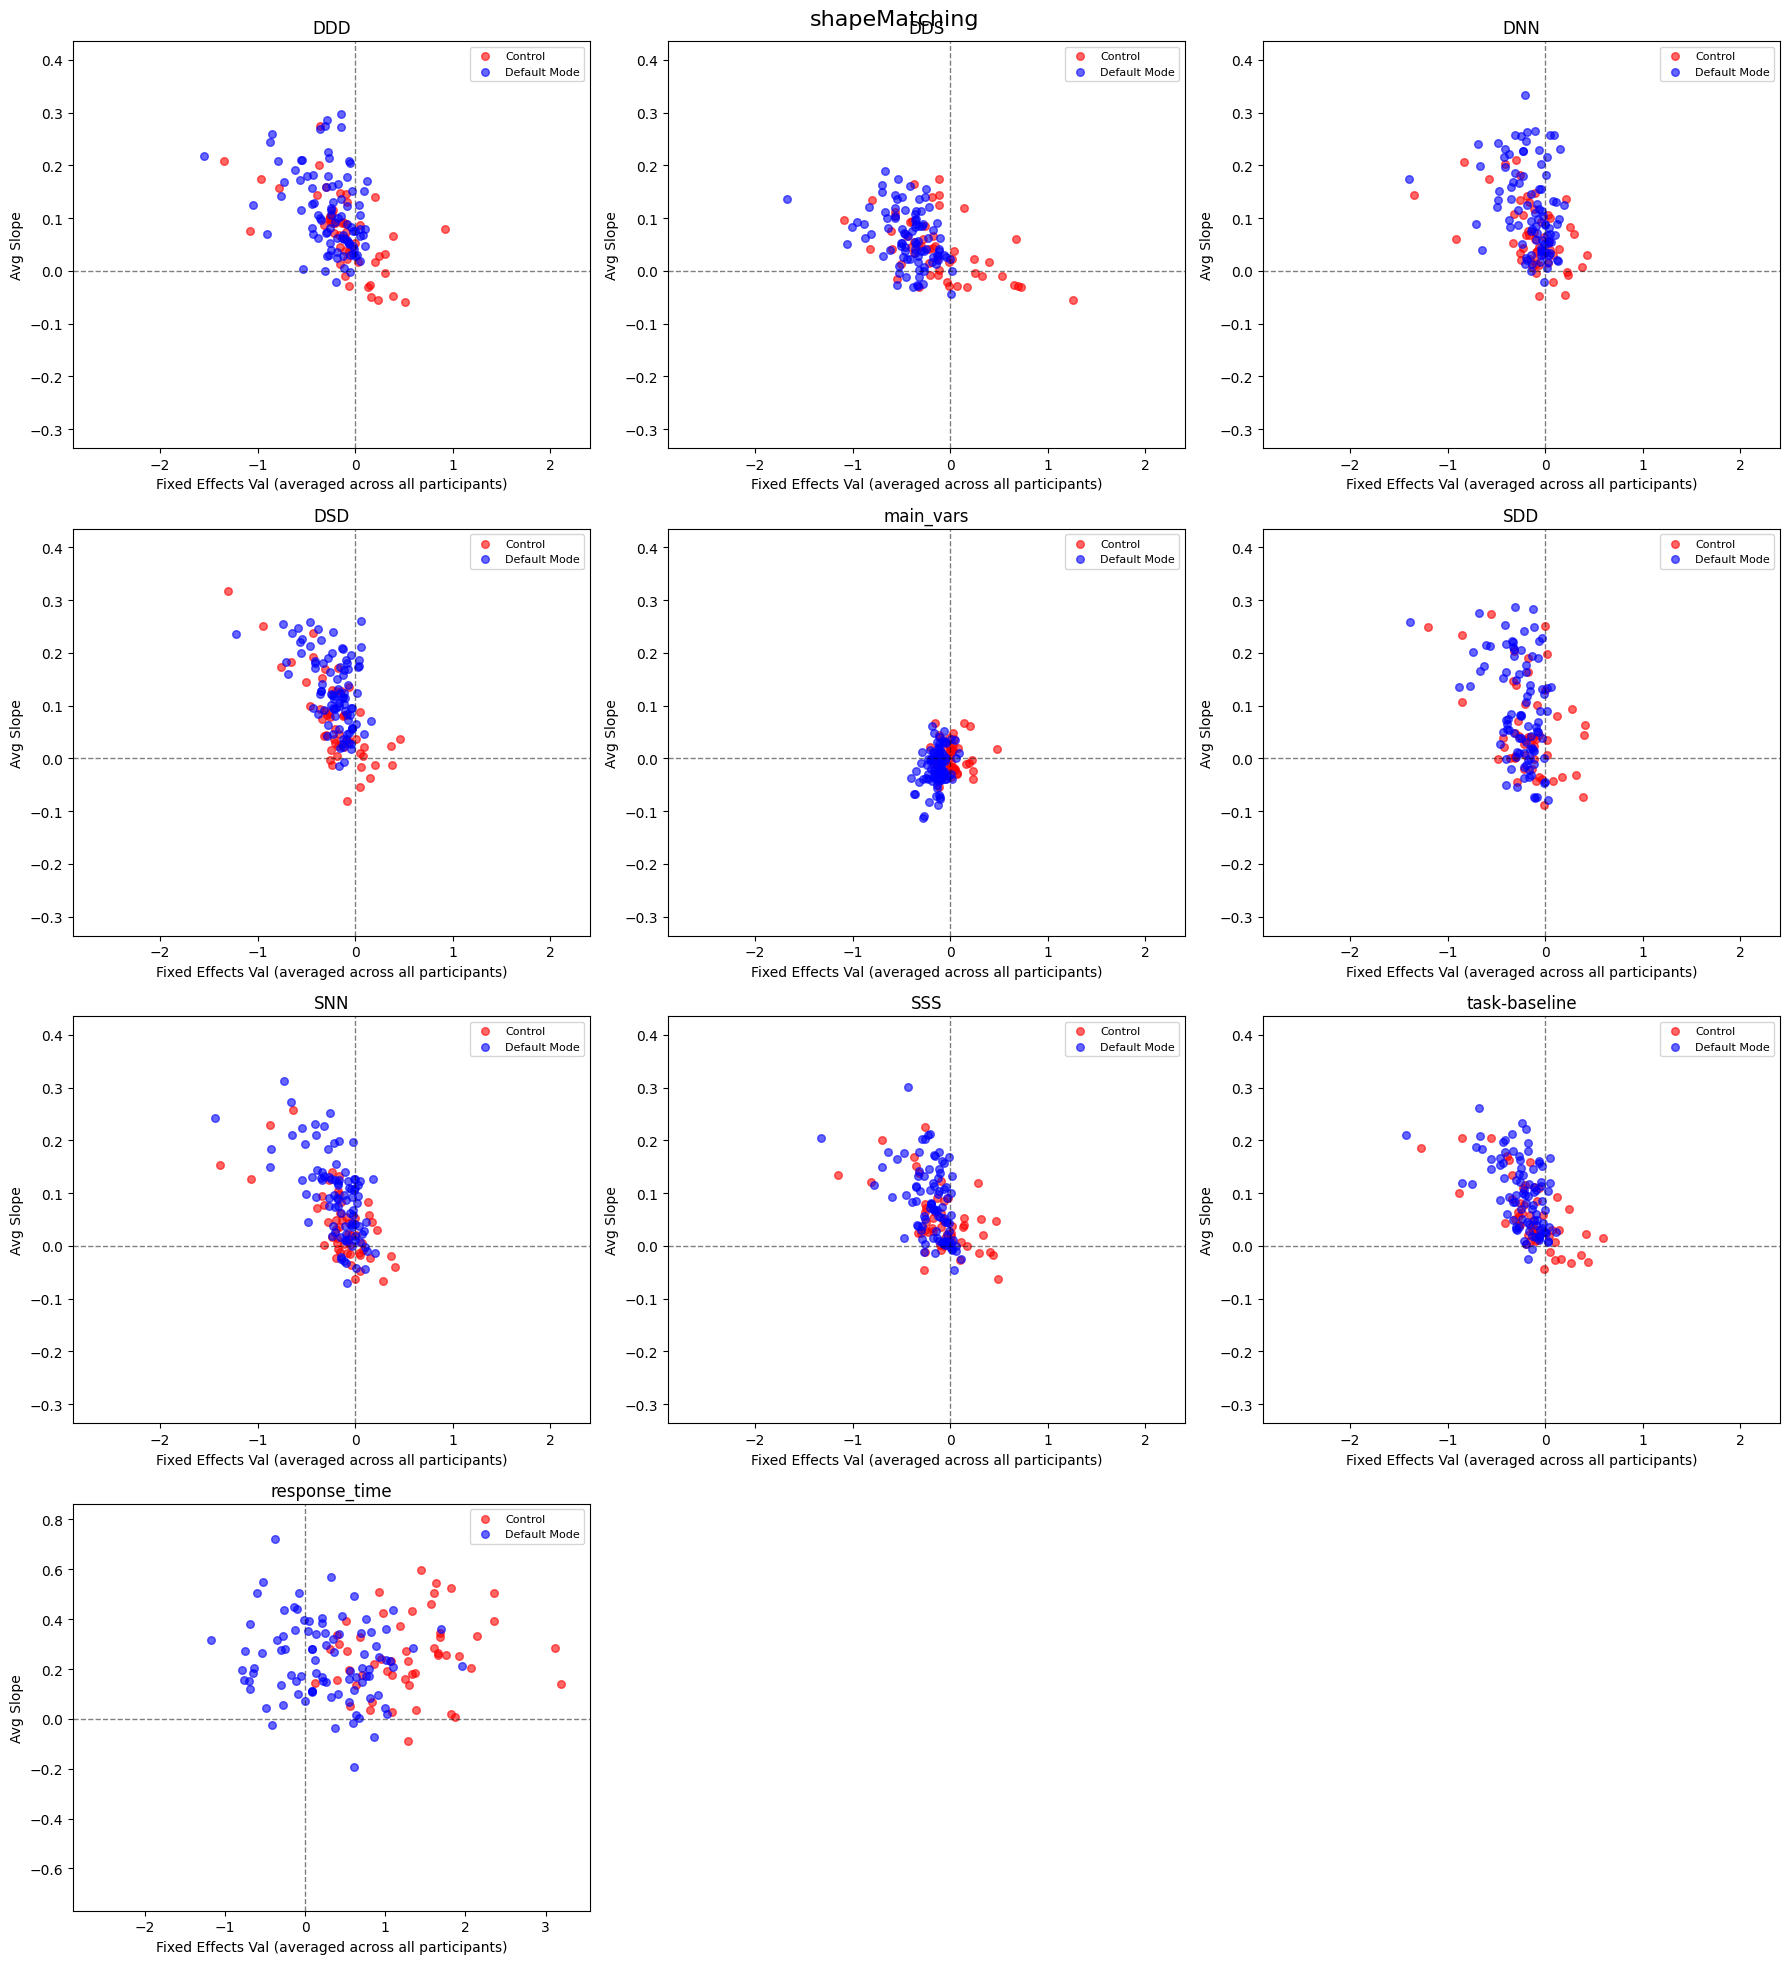

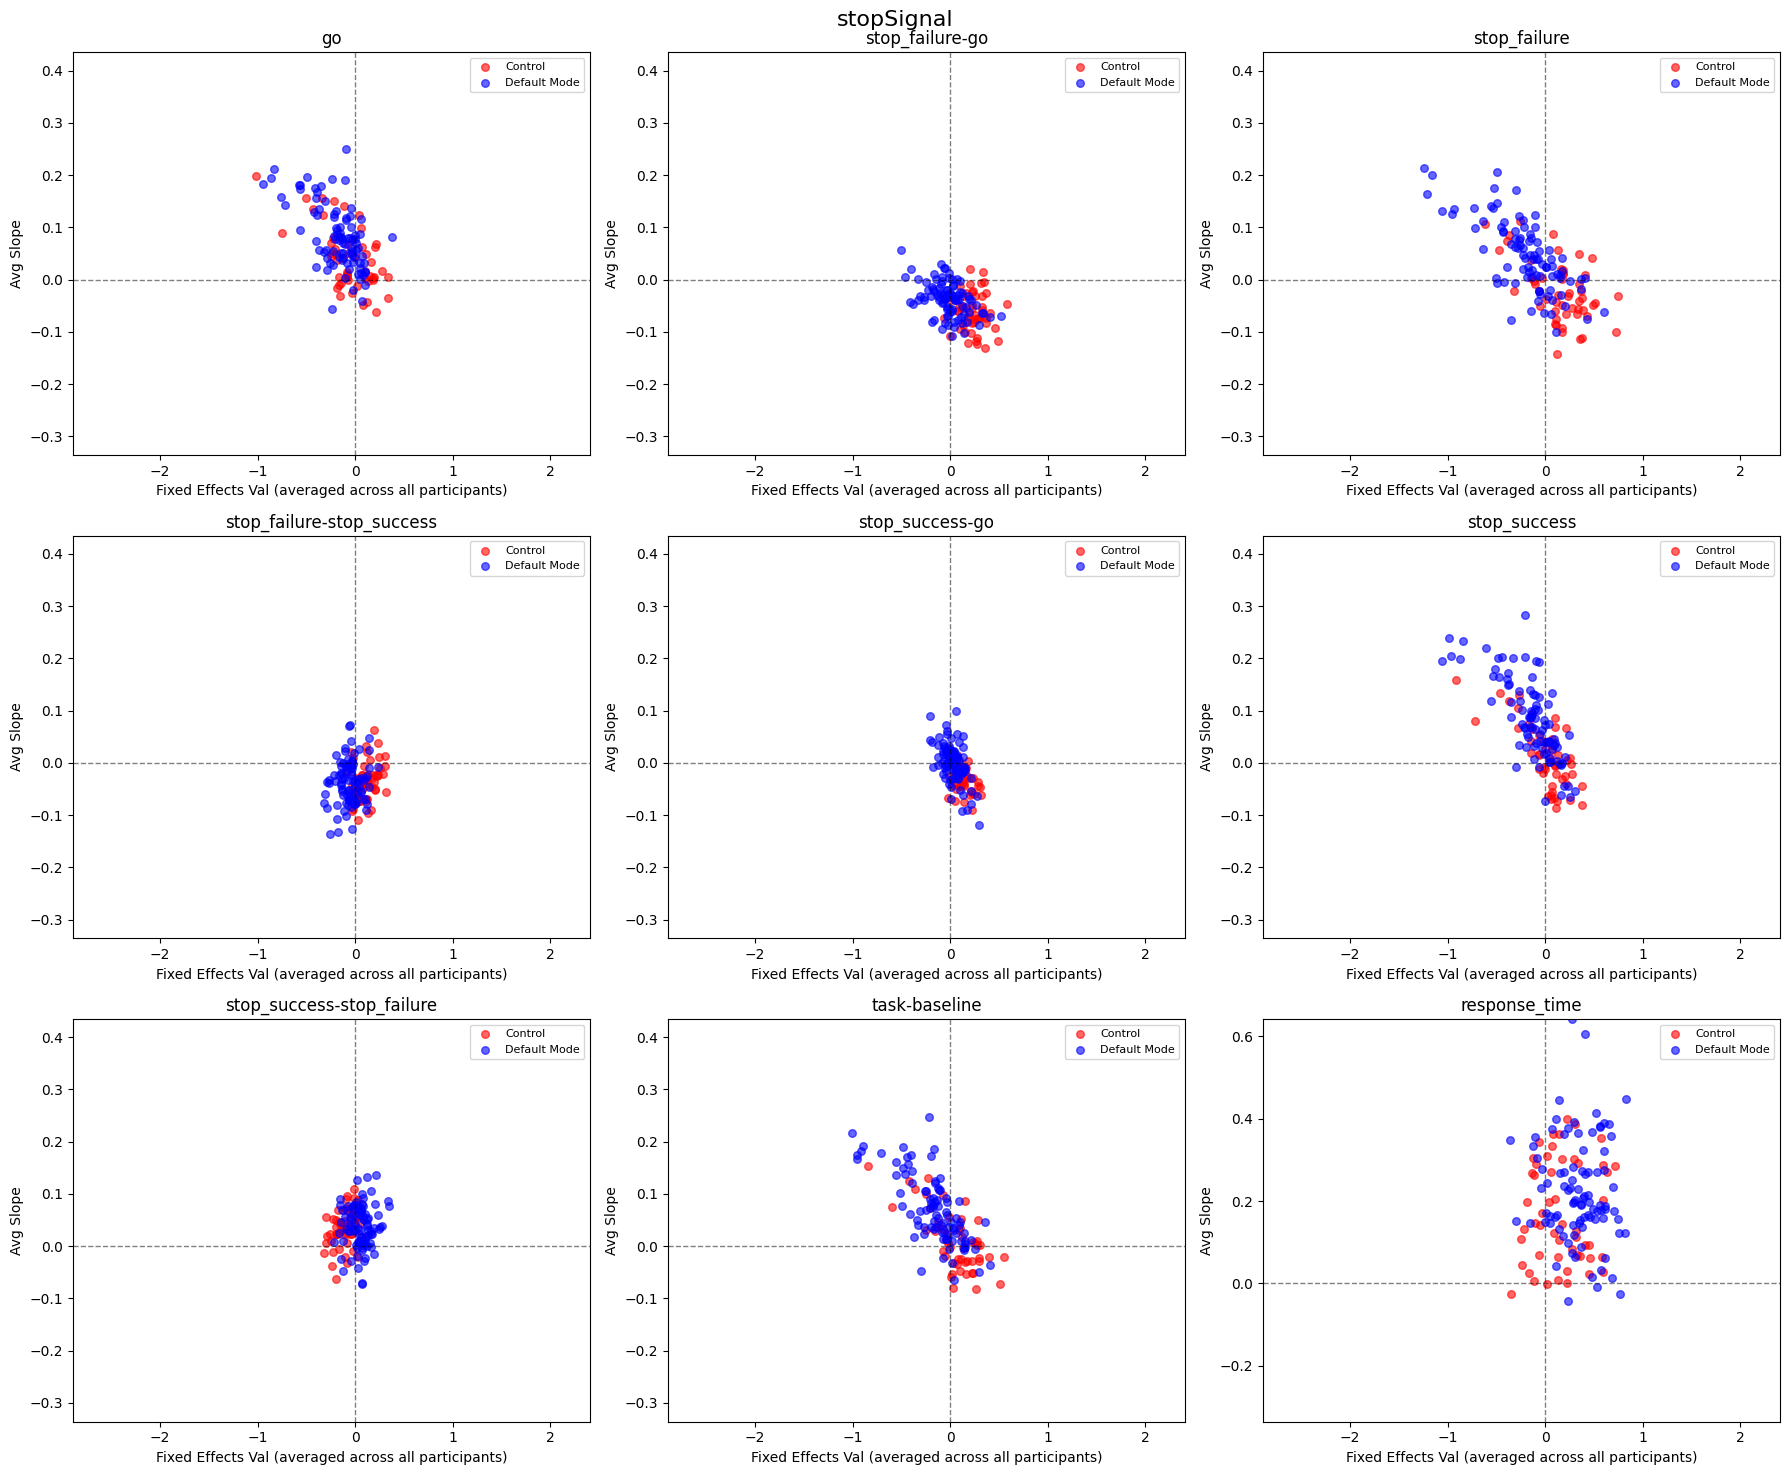

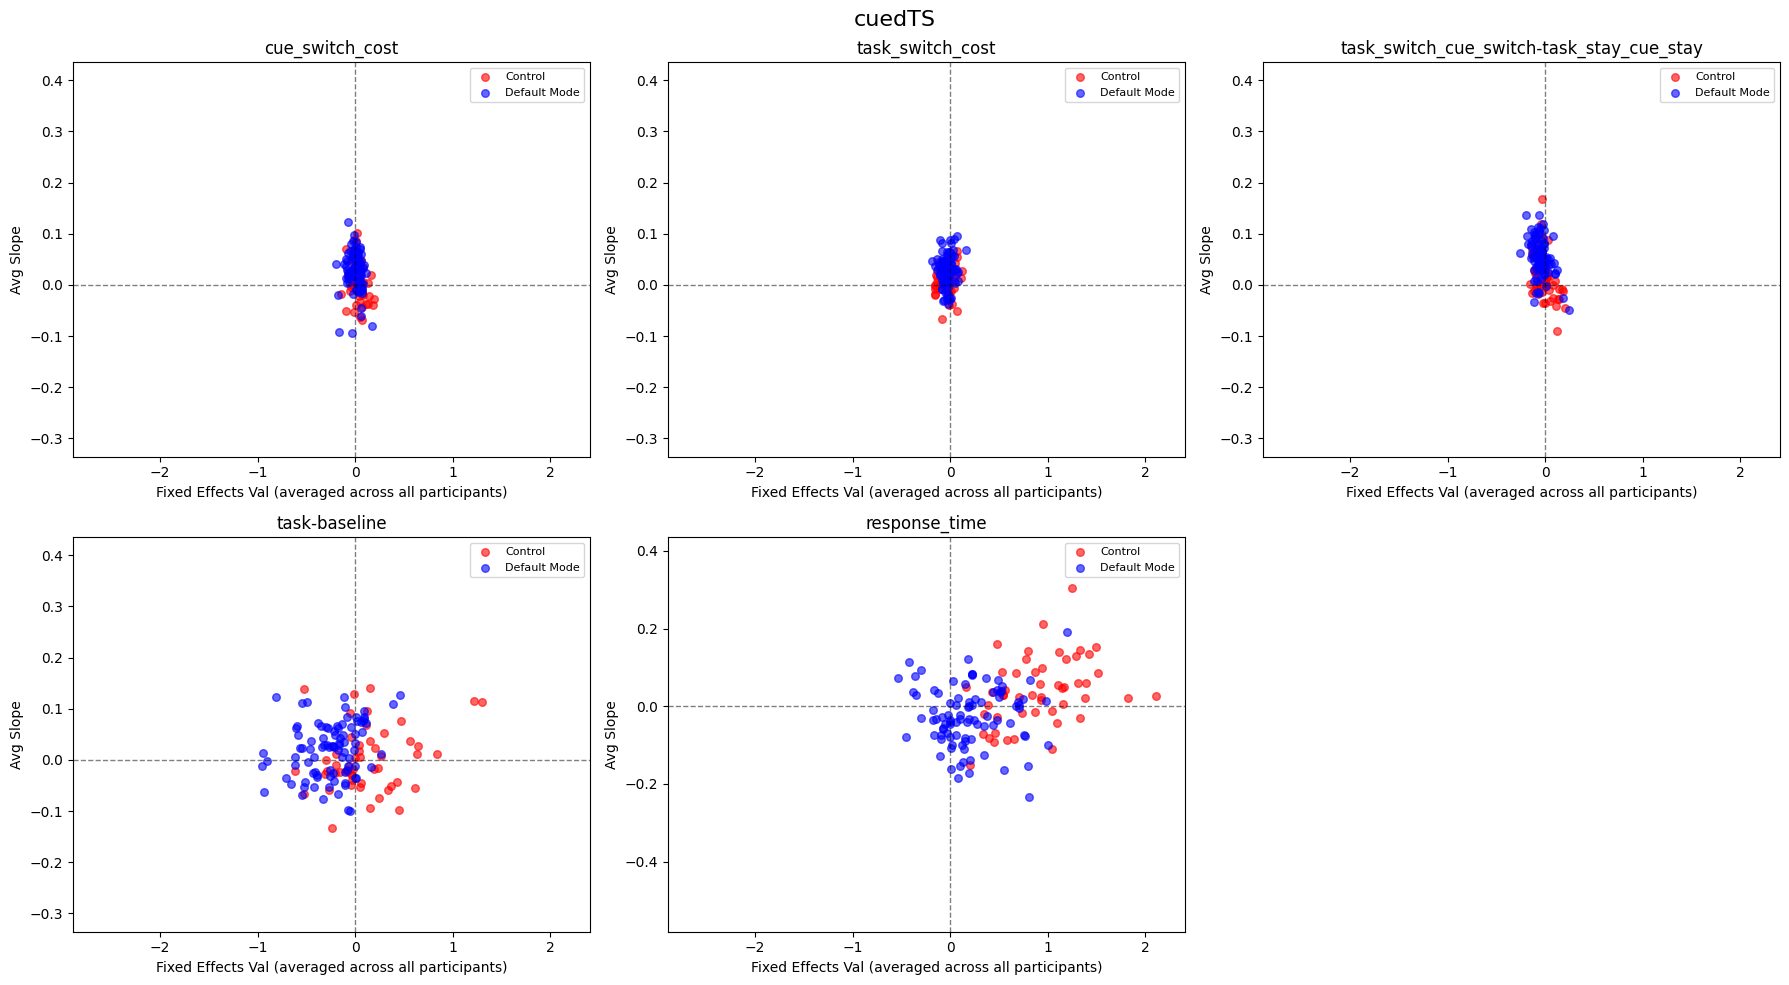

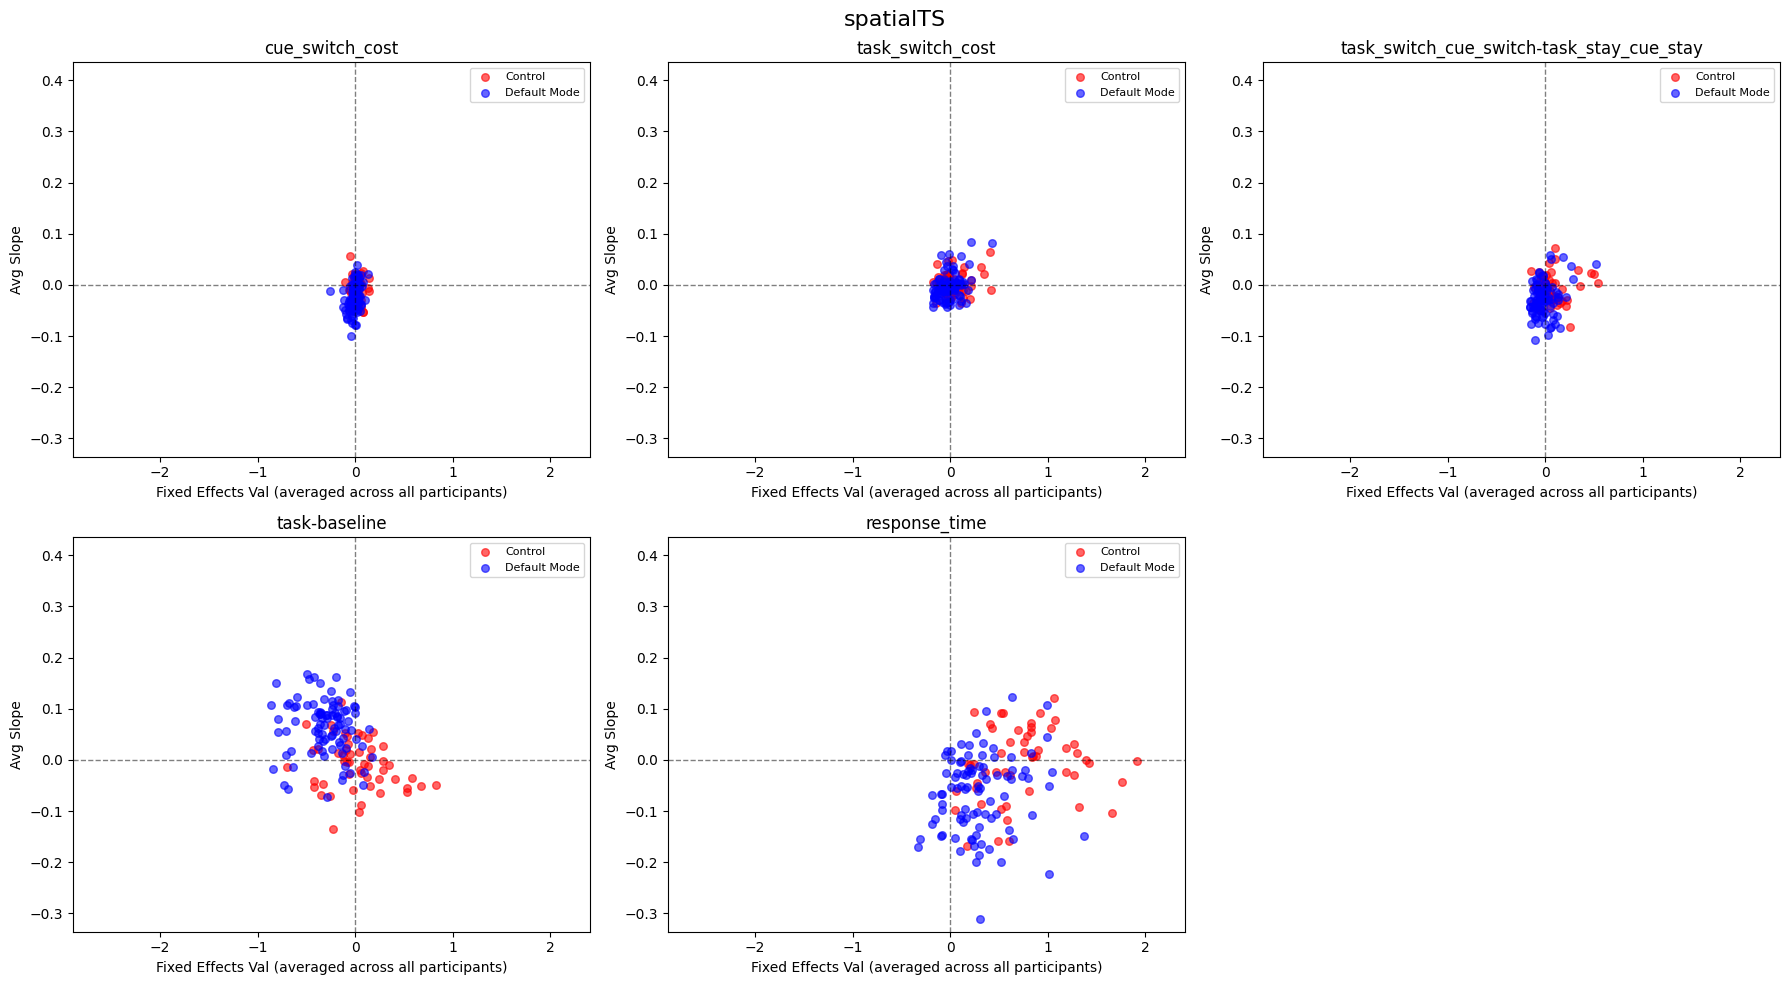

In [17]:
# plot only default mode and control regions
network_colors = {
    'Control': 'red',
    'Default Mode': 'blue'
}

for task in avg_activations.keys():
    contrasts = list(avg_activations[task].keys())
    n_contrasts = len(contrasts)
    
    if n_contrasts <= 3:
        n_rows, n_cols = 1, n_contrasts
    elif n_contrasts <= 6:
        n_rows = 2
        n_cols = int(np.ceil(n_contrasts / 2))
    elif n_contrasts <= 9:
        n_rows = 3
        n_cols = int(np.ceil(n_contrasts / 3))
    else:
        n_rows = 4
        n_cols = int(np.ceil(n_contrasts / 4))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    
    if n_contrasts == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, contrast in enumerate(contrasts):
        # Get network categories for each parcel
        parcels = list(avg_parcel_traj_results[task][contrast].keys())
        network_categories = [get_network_category(p) for p in parcels]
        
        # Plot only Control and Default Mode networks
        for network in network_colors.keys():
            mask = [cat == network for cat in network_categories]
            if any(mask):
                x_vals = [avg_activations[task][contrast]["avg_fixed_effects_val"][i] 
                         for i, m in enumerate(mask) if m]
                y_vals = [avg_activations[task][contrast]["avg_slope"][i] 
                         for i, m in enumerate(mask) if m]
                
                axes[idx].scatter(x_vals, y_vals, 
                                c=network_colors[network], 
                                label=network, 
                                alpha=0.6, 
                                s=30)
        
        axes[idx].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        axes[idx].axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        axes[idx].set_title(f"{contrast}")
        axes[idx].set_xlabel("Fixed Effects Val (averaged across all participants)")
        axes[idx].set_ylabel("Avg Slope")
        axes[idx].legend(fontsize=8, loc='best')
        if (contrast != "response_time"):
            axes[idx].set_xlim(x_min, x_max)
            axes[idx].set_ylim(y_min, y_max)
        else: 
            rt_max_x = max(x_max, np.max(avg_activations[task][contrast]["avg_fixed_effects_val"]))
            rt_max_y = max(y_max, np.max(avg_activations[task][contrast]["avg_slope"]))
            rt_min_x = min(x_min, np.min(avg_activations[task][contrast]["avg_fixed_effects_val"]))
            rt_min_y = min(y_min, np.min(avg_activations[task][contrast]["avg_slope"]))
            axes[idx].set_xlim(rt_min_x, rt_max_x)
            axes[idx].set_ylim(rt_min_y, rt_max_y)
    
    for idx in range(n_contrasts, len(axes)):
        axes[idx].set_visible(False)
    
    fig.suptitle(f"{task}", fontsize=16)
    plt.tight_layout()
    plt.show()